In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import OrderedDict
from matplotlib.collections import PatchCollection

In [2]:
class Node:
    def __init__(self, nID, nx, ny):
        self.nID = nID
        self.nx = nx
        self.ny = ny

class Cell:
    def __init__(self, cID, nvert, itr_nodes, ctr_vals):
        self.cID = cID
        self.nvert = nvert
        self.itr_nodes = itr_nodes
        self.ctr_vals = ctr_vals

In [3]:
nc = 0
nn = 0

def draw(filename_mesh,
         filename_cellsid,
         filename_connectivity,
         filename_vals,
         val_name):

    ##############################################################################################
    #                            D  A  T  A      I  M  P  O  R  T
    ##############################################################################################
    names = ['nx', 'ny']
    data = pd.read_csv(filename_mesh, delimiter=' ', skipinitialspace=True, names=names)    
    nn = data.shape[0]
    nodes = [Node(i, data.nx[i-1], data.ny[i-1]) for i in range(1, nn+1)]


    # Dataset s ID bunek, hranicnim ID, pocty vnitrnich uzlu a ID sousedicich bunek
    names1 = ['cID', 'IDbdry', 'nvert', 'nbdrcells']
    data1 = pd.read_csv(filename_cellsid, delimiter=' ', skipinitialspace=True, names=names1)
    nc = data1.shape[0]
    cells = [Cell(data1.cID[k-1],data1.nvert[k-1],[],[]) for k in range(1, nc+1)]


    # Dataset vnitrnich uzlu a seznam sousedicich bunek pro kazdou bunku
    names2 = ['cID', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'ng1', 'ng2', 'ng3', 'ng4', 'ng5', 'ng6']
    data2 = pd.read_csv(filename_connectivity, delimiter=' ', skipinitialspace=True, names=names2)

    # Dataset hodnot v bunkach
    names3 = ['cx', 'cy', 'cu', 'cv', 'crho', 'cp', 'cEni']
    data3 = pd.read_csv(filename_vals, delimiter=' ', skipinitialspace=True, names=names3)

    ###################################
    # END OF IMPORT
    ###################################


    ##############################################################################################
    #                                  U  T  I  L  I  T  Y
    ##############################################################################################
    # Naplni bunky jejich seznamem vnitrnich uzlu.
    # if-y pro ruzne pocty vrcholu bunek.
    # Vrcholy je nutne ukladat po smeru hodinovych rucicek kvuli vykresleni.
    for k in range(nc):

        if cells[k].nvert == 3:
            cells[k].itr_nodes = [data2.v3[k], data2.v2[k], data2.v1[k]]

        if cells[k].nvert == 4:
            cells[k].itr_nodes = [data2.v4[k], data2.v3[k], data2.v2[k], data2.v1[k]]

        elif cells[k].nvert == 5:
            cells[k].itr_nodes = [data2.v5[k], data2.v4[k], data2.v3[k], data2.v2[k], data2.v1[k]]

        elif cells[k].nvert == 6:
            cells[k].itr_nodes = [data2.v6[k], data2.v5[k], data2.v4[k], data2.v3[k], data2.v2[k], data2.v1[k]]

        else:
            raise ValueError('Procedura neni implementovana pro ',cells[k].nvert,' vrcholu bunky'
                             ,cells[k].cID, '.')
    ##############################################

    ###############################################################################
    # Nakresli caru mezi 2 vybranymi uzly
    # Neni pouzite, ale muze se hodit
    def connect_nodes(i, j): 
        ax.plot([nodes[i].nx, nodes[j].nx], [nodes[i].ny, nodes[j].ny], 'ro-')
    ###############################################################################

    ###############################################################################
    # Naplni bunky seznamem hodnot ulozenych v cell-centru
    for k in range(nc):
        cells[k].ctr_vals = [data3.cx[k], data3.cy[k], data3.cu[k],
                             data3.cv[k], data3.crho[k], data3.cp[k],
                            data3.cEni[k]]
    ###############################################################################

    ###############################################################################
    # Vykresleni uzlu
    x = [nodes[i].nx for i in range(nn)]
    y = [nodes[j].ny for j in range(nn)]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x,y)
    ax.set_title('VISU Nodes')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    ###############################################################################

    ###############################################################################
    # Pripravi pole koordinatu pro vykresleni
    def get_cvert_coords_x(cell_ID):
        coord_x = [nodes[i-1].nx for i in cells[cell_ID].itr_nodes]

        return coord_x

    def get_cvert_coords_y(cell_ID):
        coord_y = [nodes[j-1].ny for j in cells[cell_ID].itr_nodes]

        return coord_y
    ###############################################################################


    ###############################################################################
    #                                C O L O R M A P
    ###############################################################################

    def cb_min(par):
        ls =  [cells[k].ctr_vals for k in range(nc)]

        if par == 'crho':
            selector = 5
        elif par == 'cp':
            selector = 6
        elif par == 'cEni':
            selector = 7
        else:
            raise ValueError('Neni promenna:' ,par,)
        cb_min = min((ls)[selector])
        return cb_min

    def cb_max(par):
        ls =  [cells[k].ctr_vals for k in range(nc)]

        if par == 'crho':
            selector = 5
        elif par == 'cp':
            selector = 6
        elif par == 'cEni':
            selector = 7
        else:
            raise ValueError('Neni promenna:' ,par,)
        cb_max = max((ls)[selector])
        return cb_max

    def norm_color_list(par):
        selector = 0

        if par == 'crho':
            selector = 5
        elif par == 'cp':
            selector = 6
        elif par == 'cEni':
            selector = 7
        else:
            raise ValueError('Nemuzu vykreslit' ,par,)

        ls1 =  [cells[k].ctr_vals[selector] for k in range(nc)]

        norm = mpl.colors.Normalize(vmin=round(cb_min(par)),vmax=round(cb_max(par)))

        nls = norm(ls1)
        return nls

    # Seznam hodnot pro obarveni bunek
    ls1 =  [cells[k].ctr_vals for k in range(nc)]


    ###############################################################################
    #                               P  L  O  T 
    ###############################################################################
    fig, ax = plt.subplots()
    fig1, ax1 = plt.subplots()
    #ax.set_xlim([-0.6, 0.6])
    #ax.set_ylim([-0.6, 0.6])
    patches = []

    for k in range(nc):
        cx = get_cvert_coords_x(k)
        cy = get_cvert_coords_y(k)
        points = np.column_stack((cx,cy))

        polygon = mpl.patches.Polygon(points)
        patches.append(polygon)

        colors = norm_color_list(val_name)


    # General plotting settings
    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 22}

    mpl.rc('font', **font)

    # Coloured plot
    plt.set_cmap('jet')
    p = PatchCollection(patches, alpha=0.8)
    p.set_array(colors)
    p.set_edgecolor("k")
    ax.add_collection(p)
    fig.colorbar(p, ax=ax, norm=colors)

    plt.rcParams["figure.figsize"] = [40,30]

    ax.autoscale_view()
    ax.set_title('Contour Plot')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.savefig('vystupni_meshplot.png')
    
    # Mesh plot
    q = PatchCollection(patches, alpha=0.8)
    q.set_edgecolor("k")
    q.set_facecolor("y")
    ax1.add_collection(q)

    ax1.autoscale_view()
    ax1.set_title('Mesh Plot')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    fig1.savefig('vystupni_sit.png')
    plt.show()

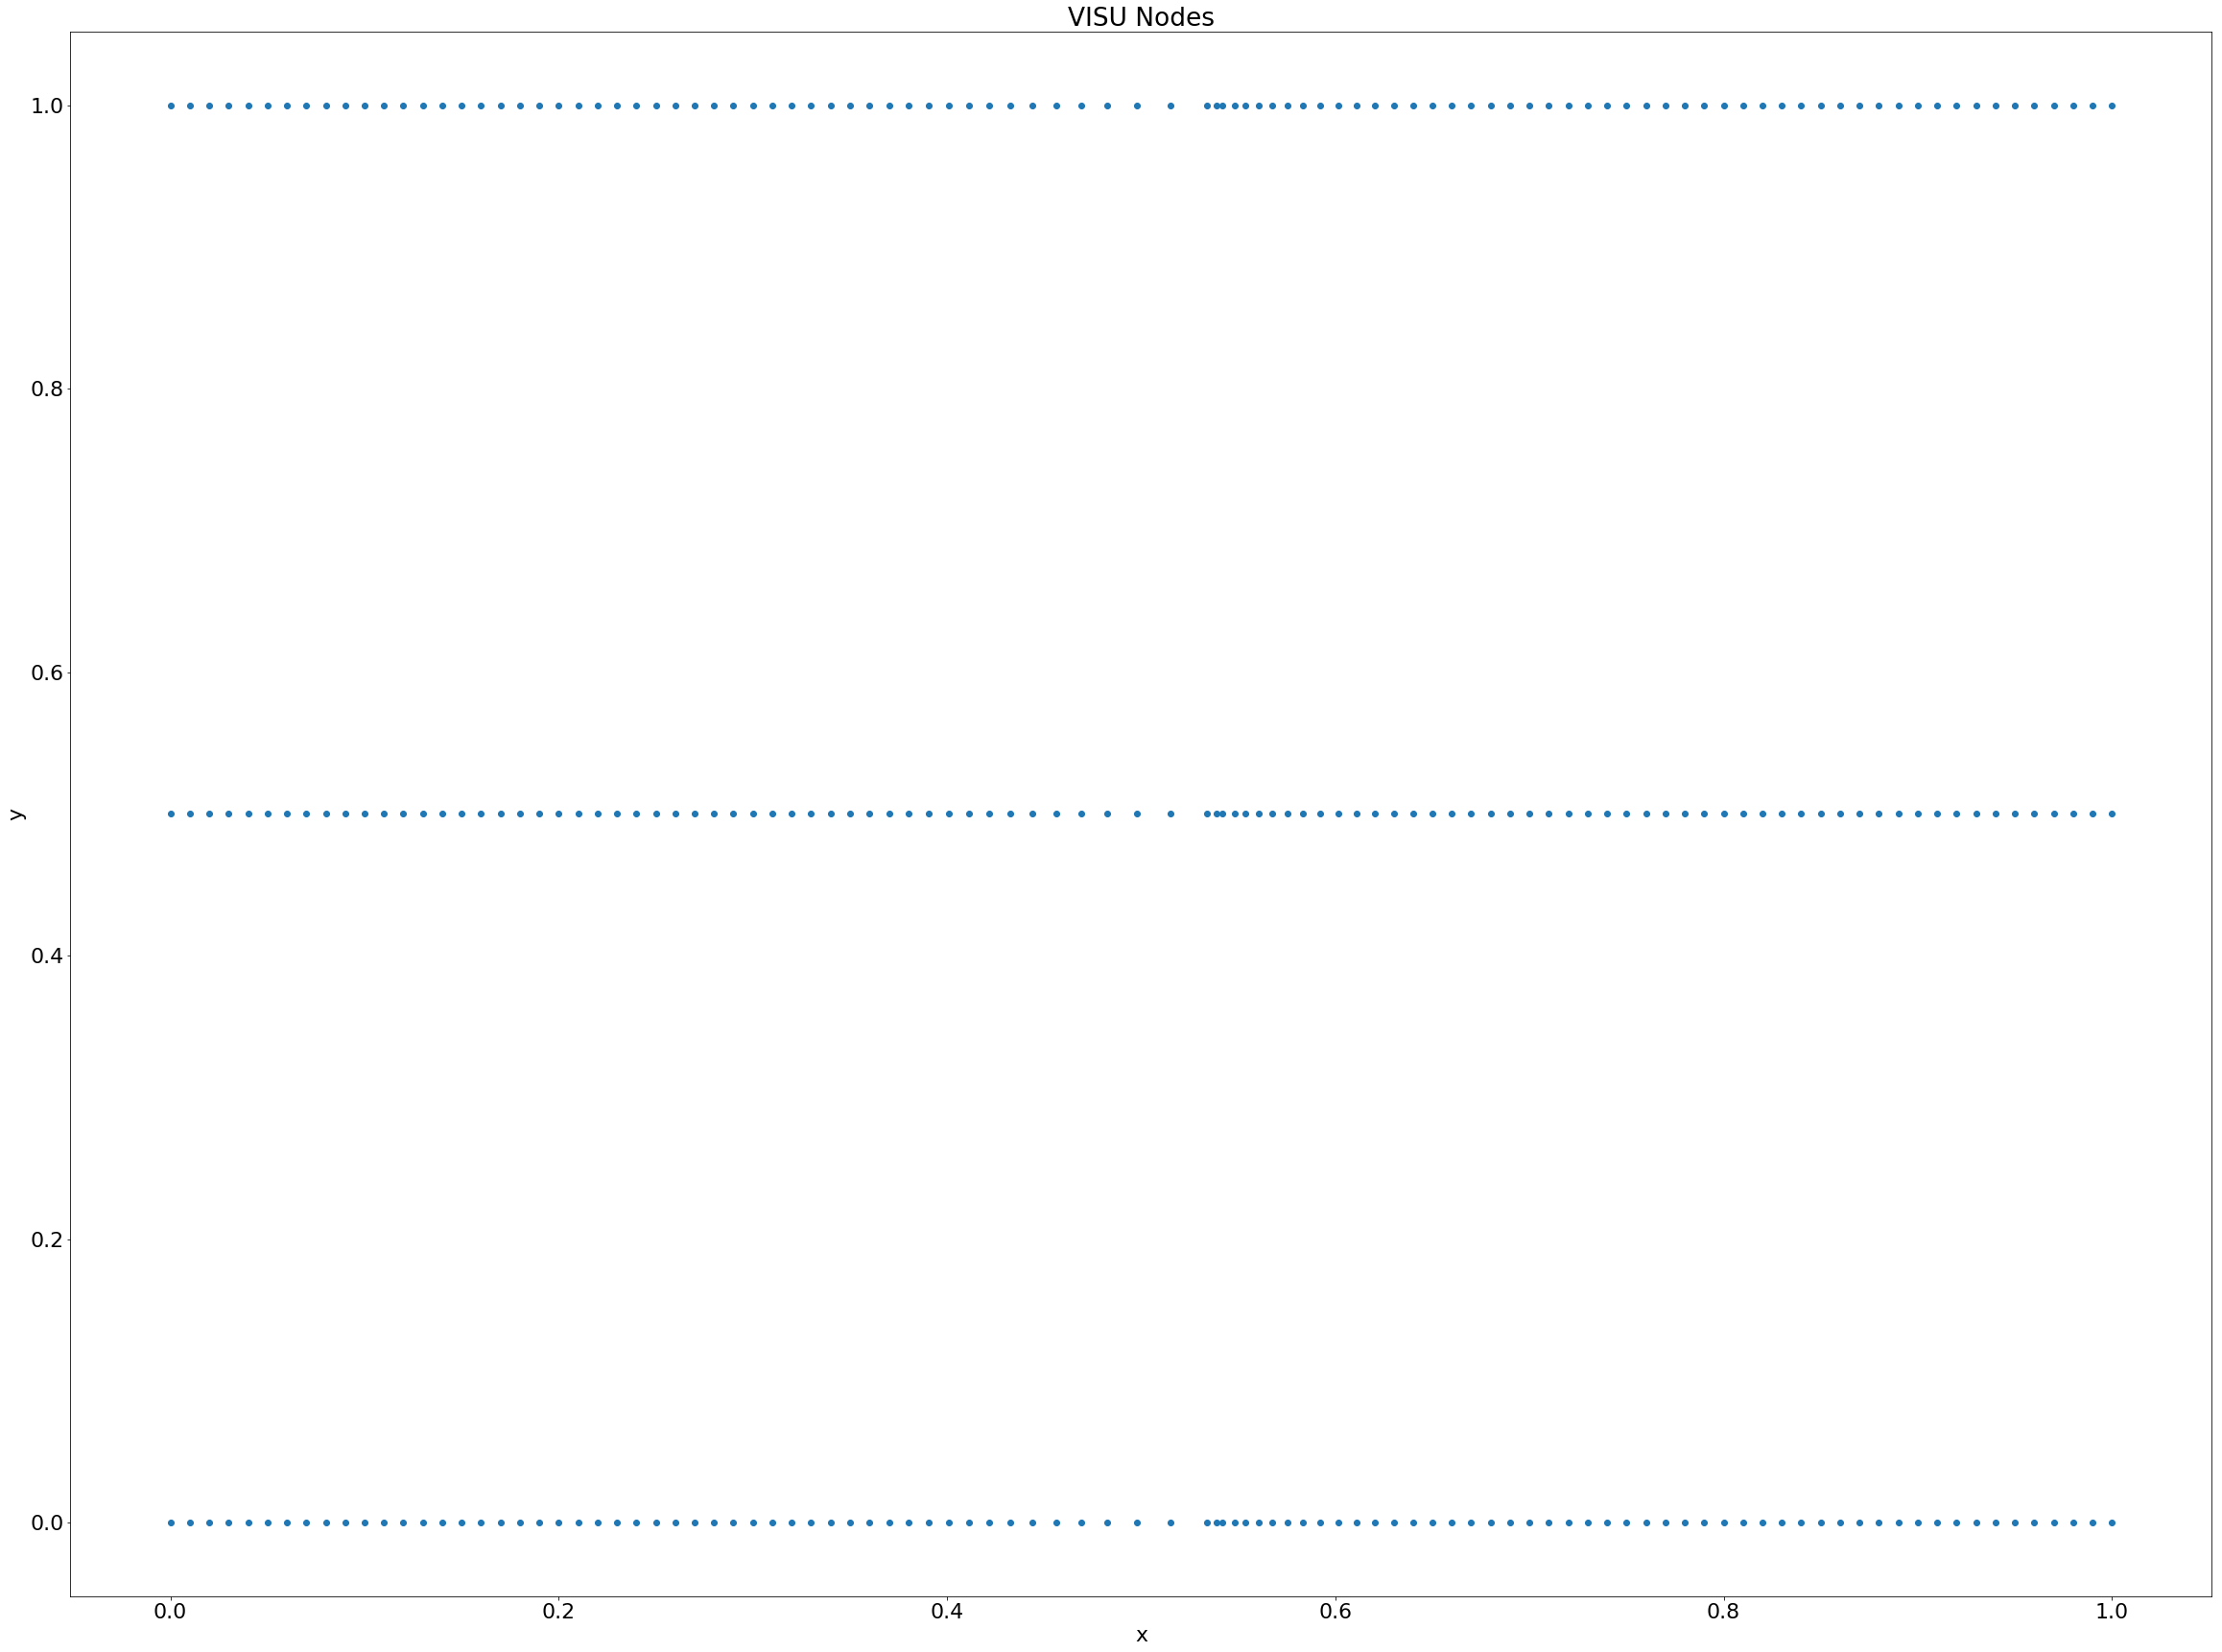

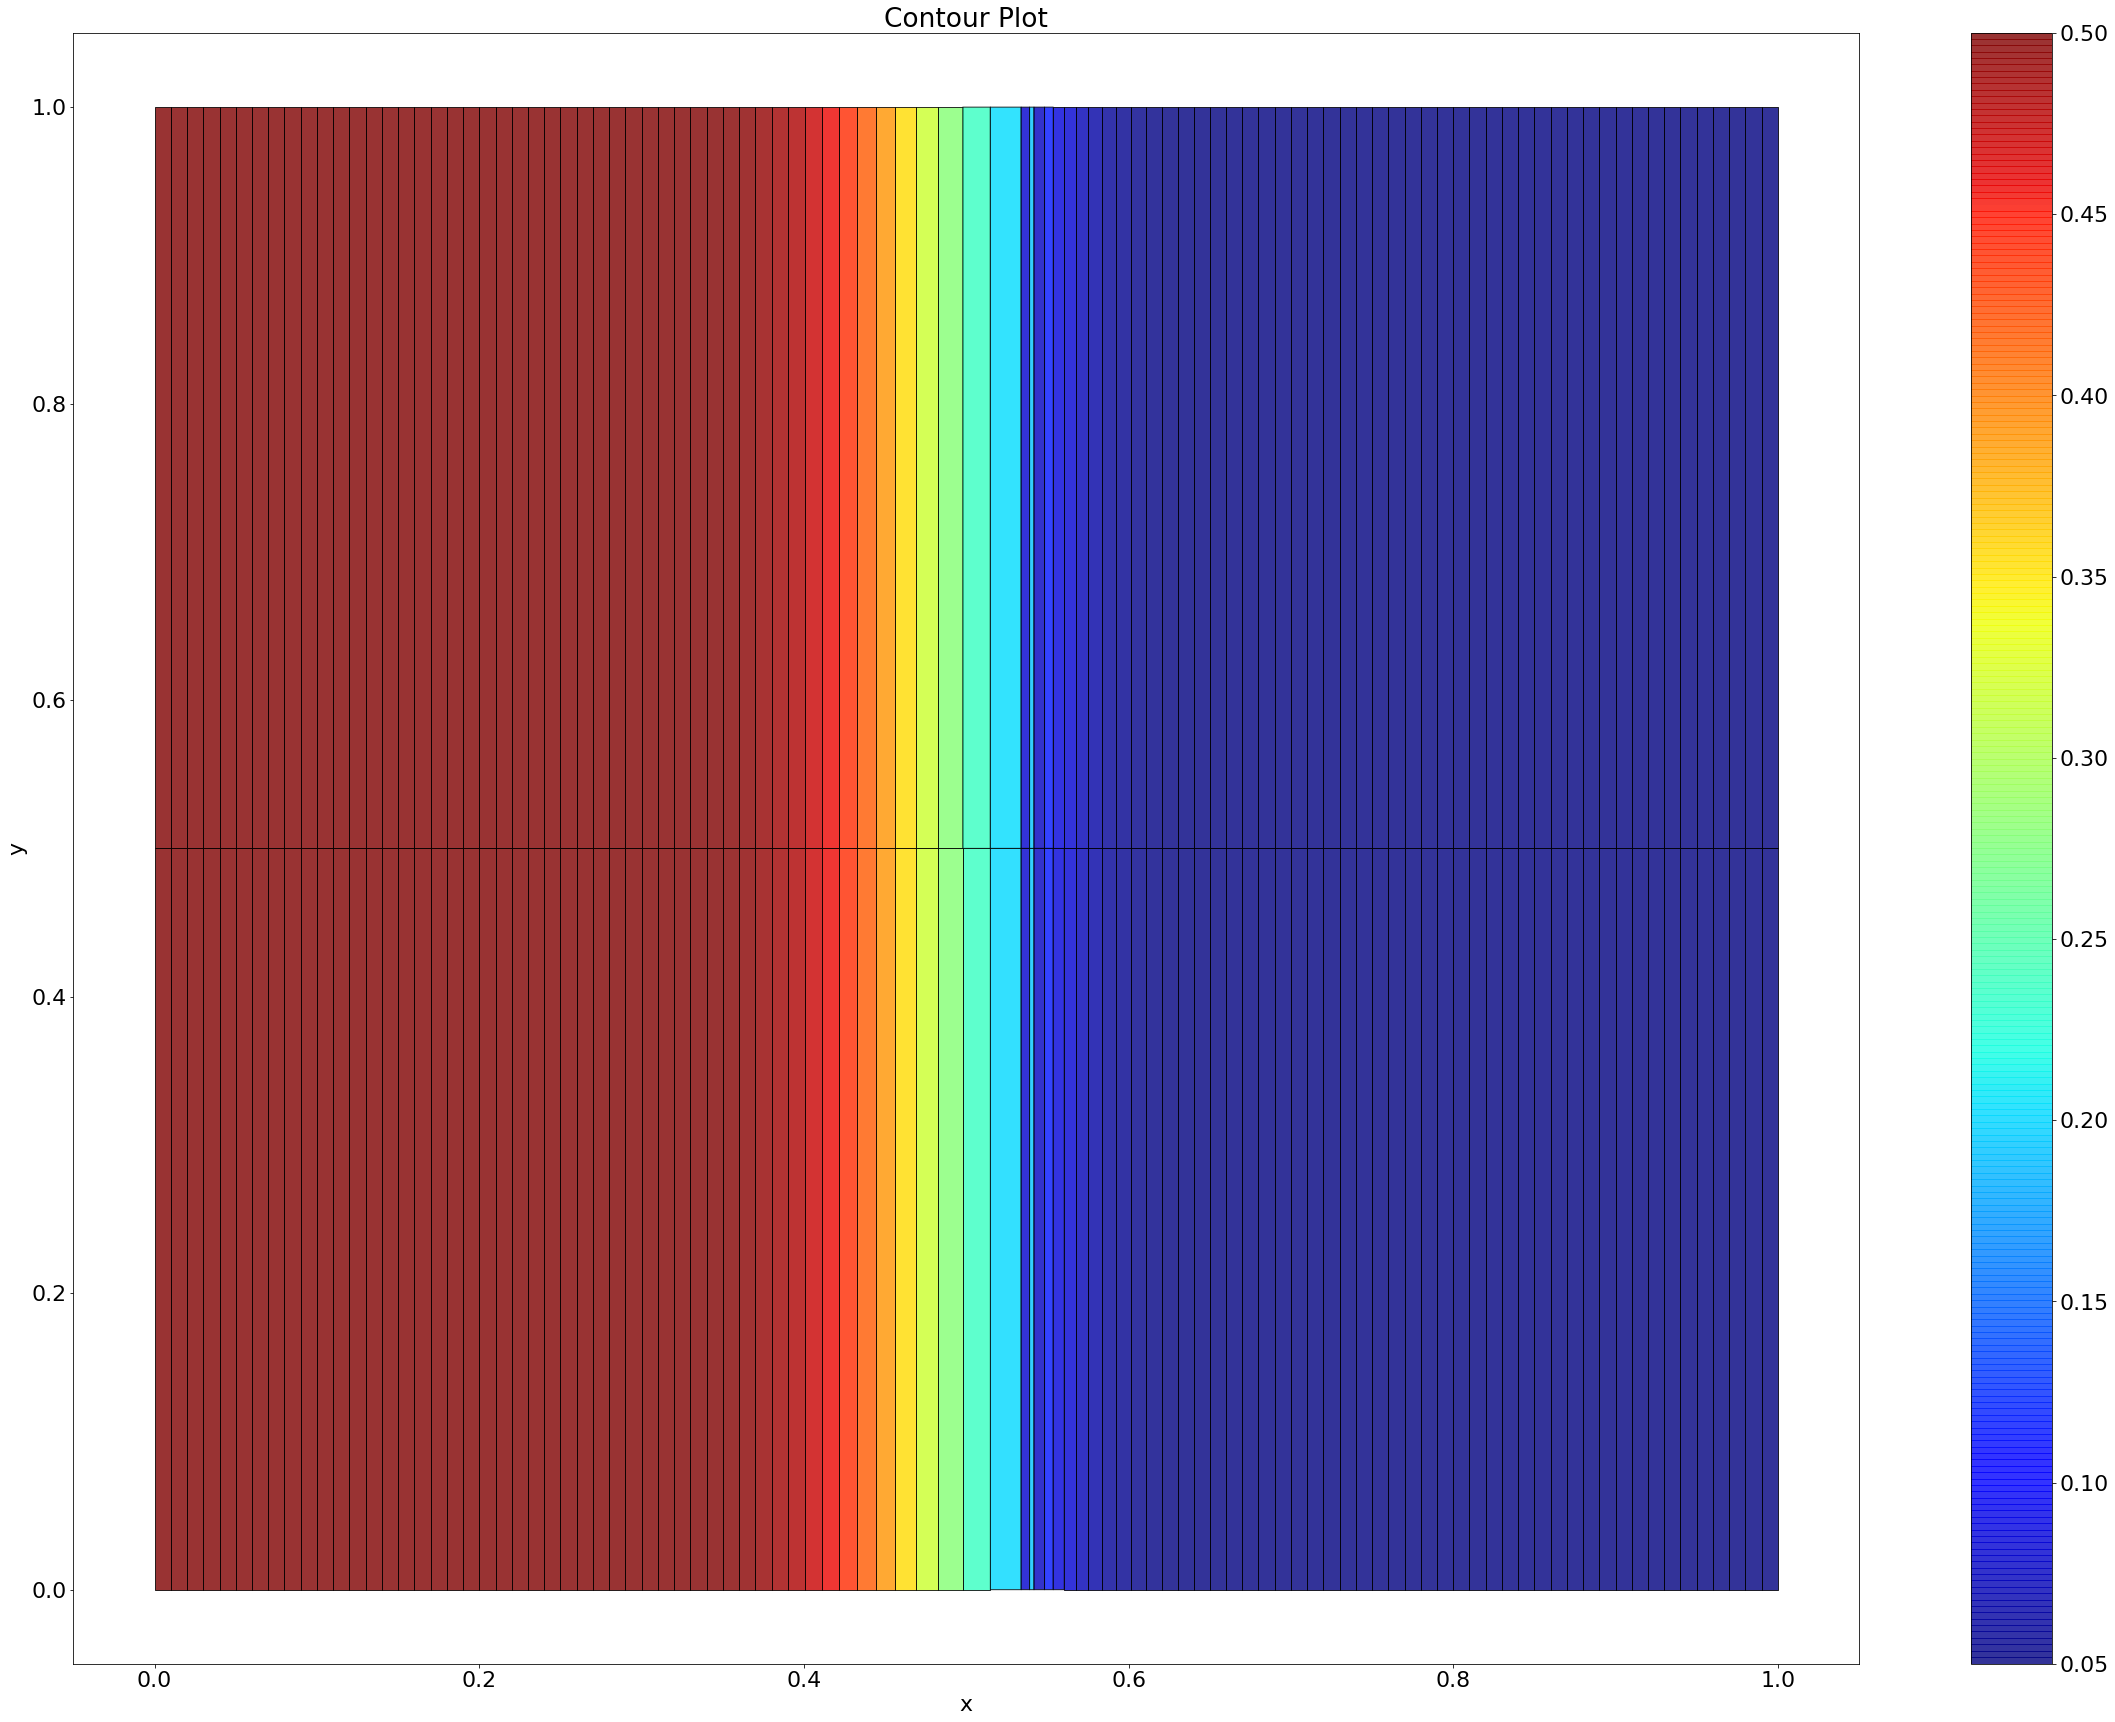

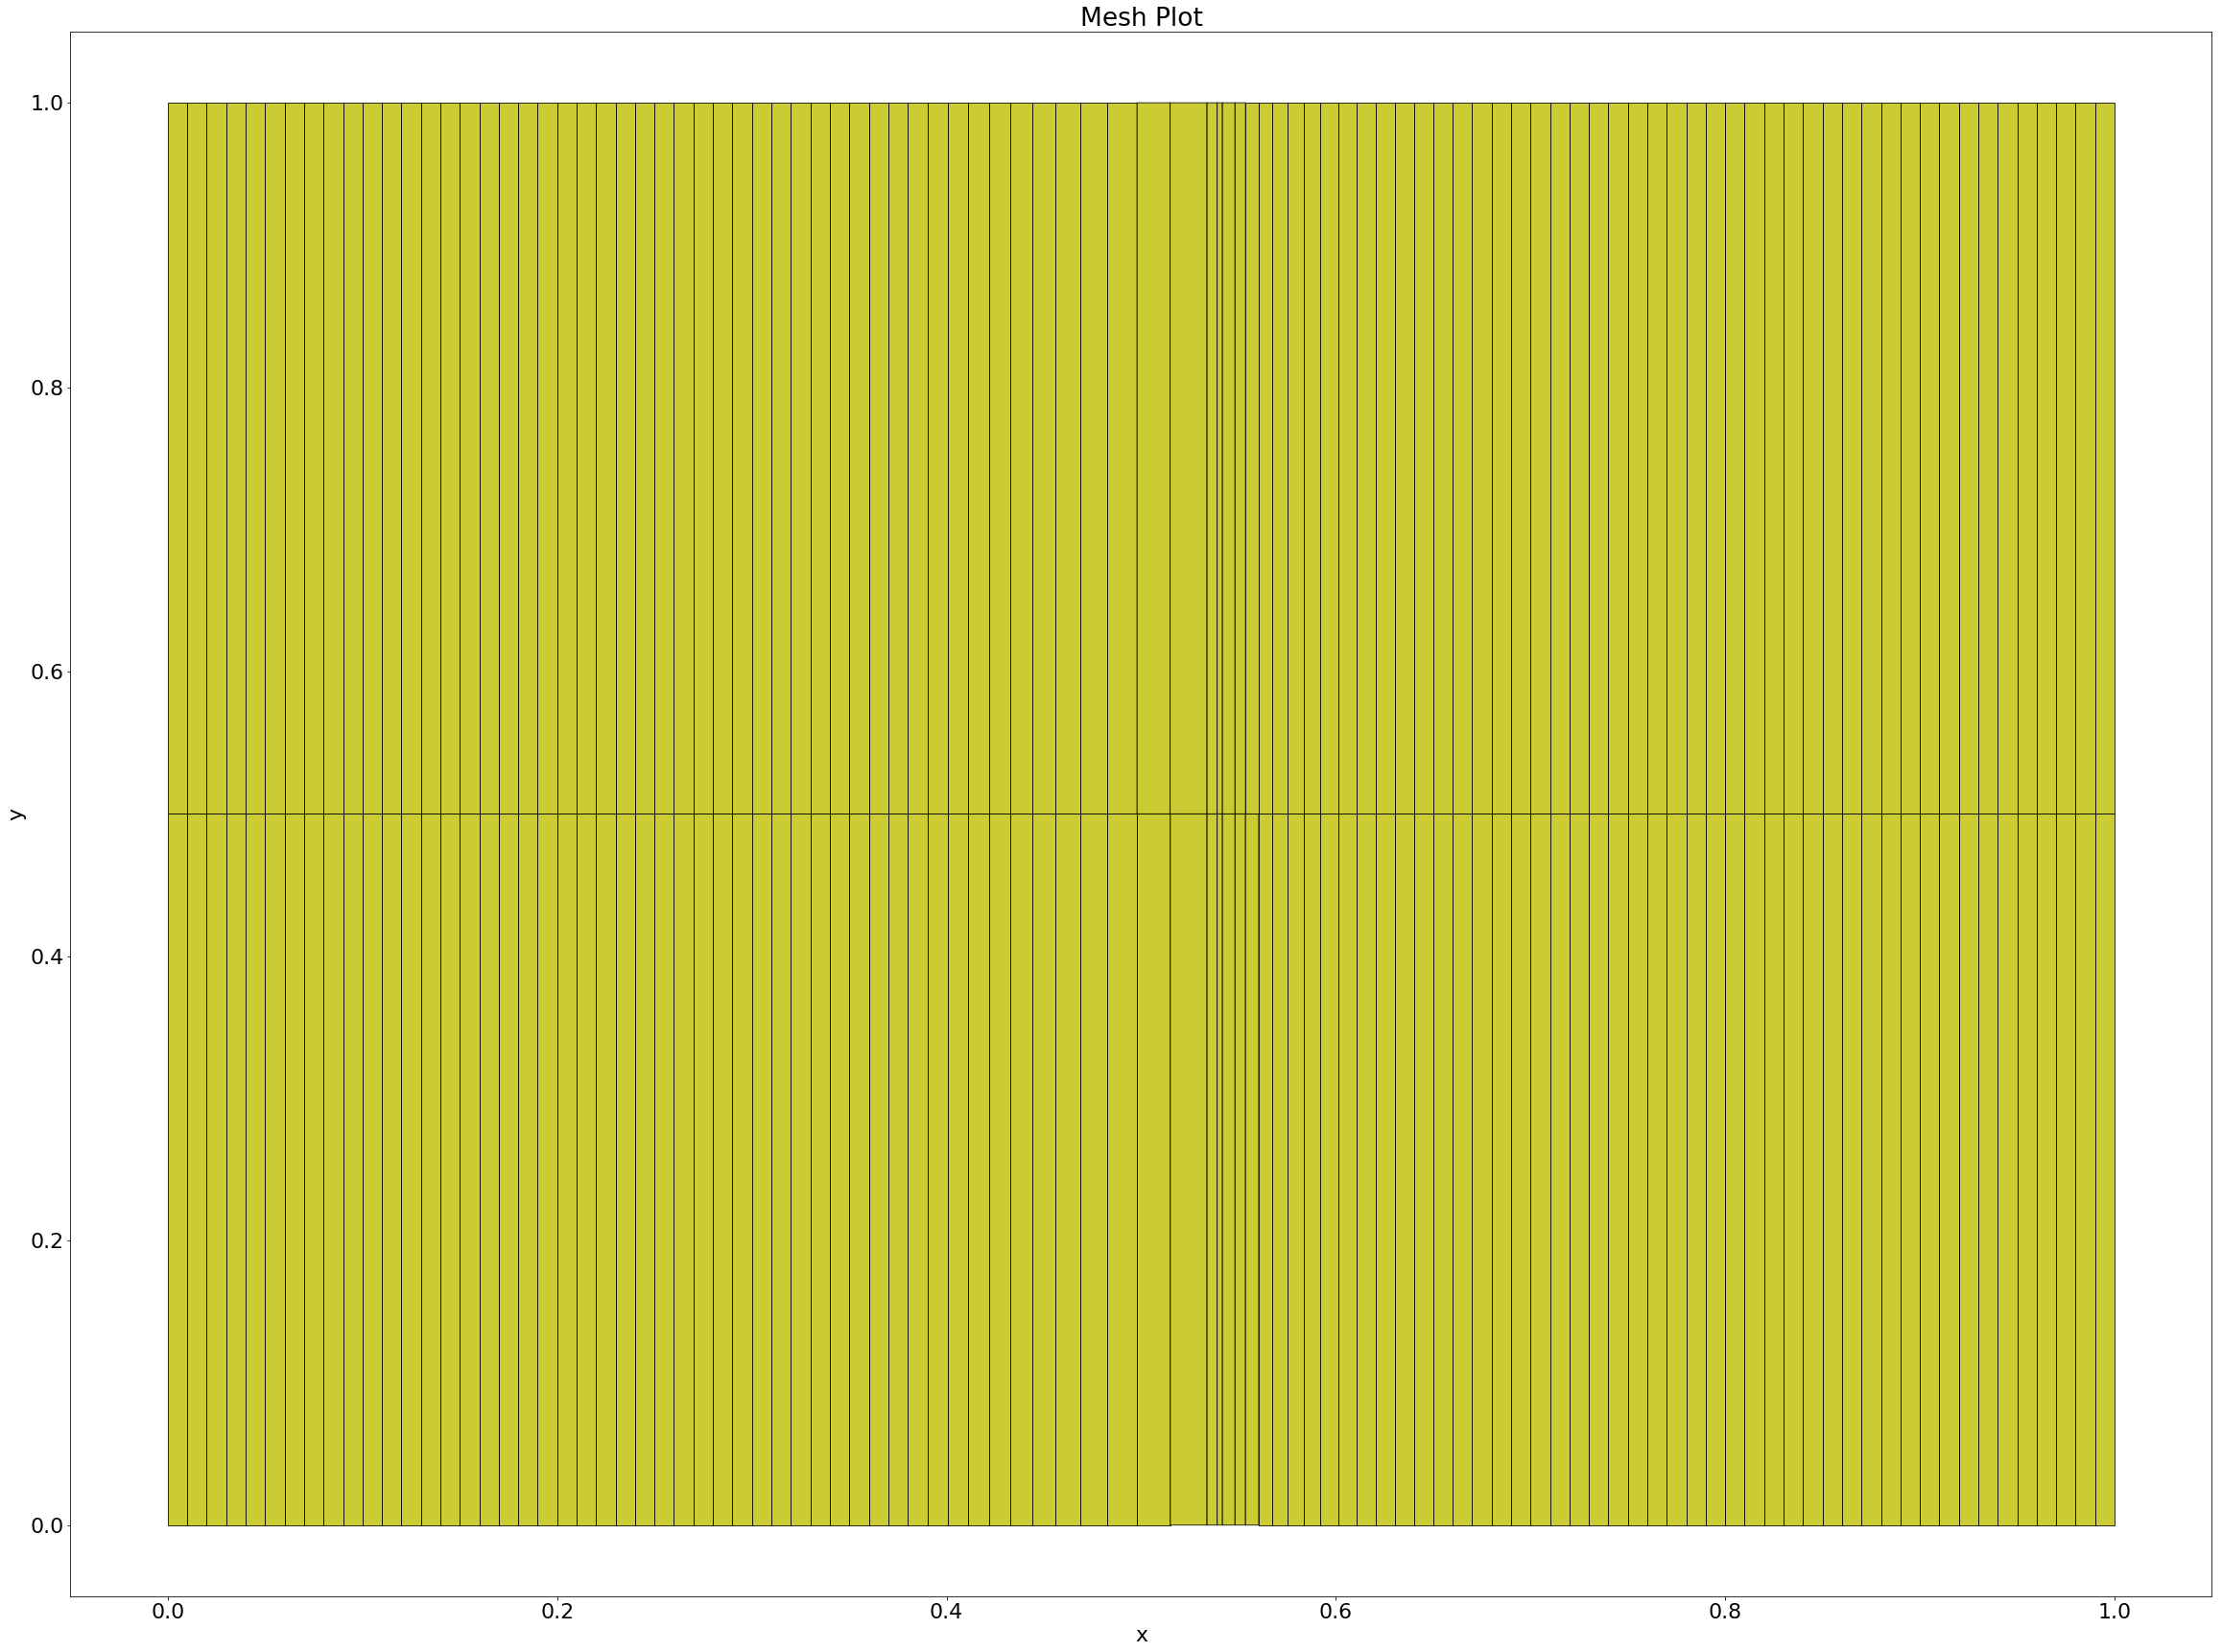

In [10]:
# Draw routine params:
#        1)Node coord file
#        2)Cell attribute file
#        3)Connectivity file
#        4)Cell value file
#        5)Value to be plotted ('cEni' \\ 'crho' \\ 'cp')

draw(r"/Users/Ivan/Desktop/Visu/mesh_005_sod.dat",
     r"/Users/Ivan/Desktop/Visu/input_cellsid_sod.dat",
     r"/Users/Ivan/Desktop/Visu/input_cnconn_sod.dat",
     r"/Users/Ivan/Desktop/Visu/vals_005_sod.dat",
     'crho')

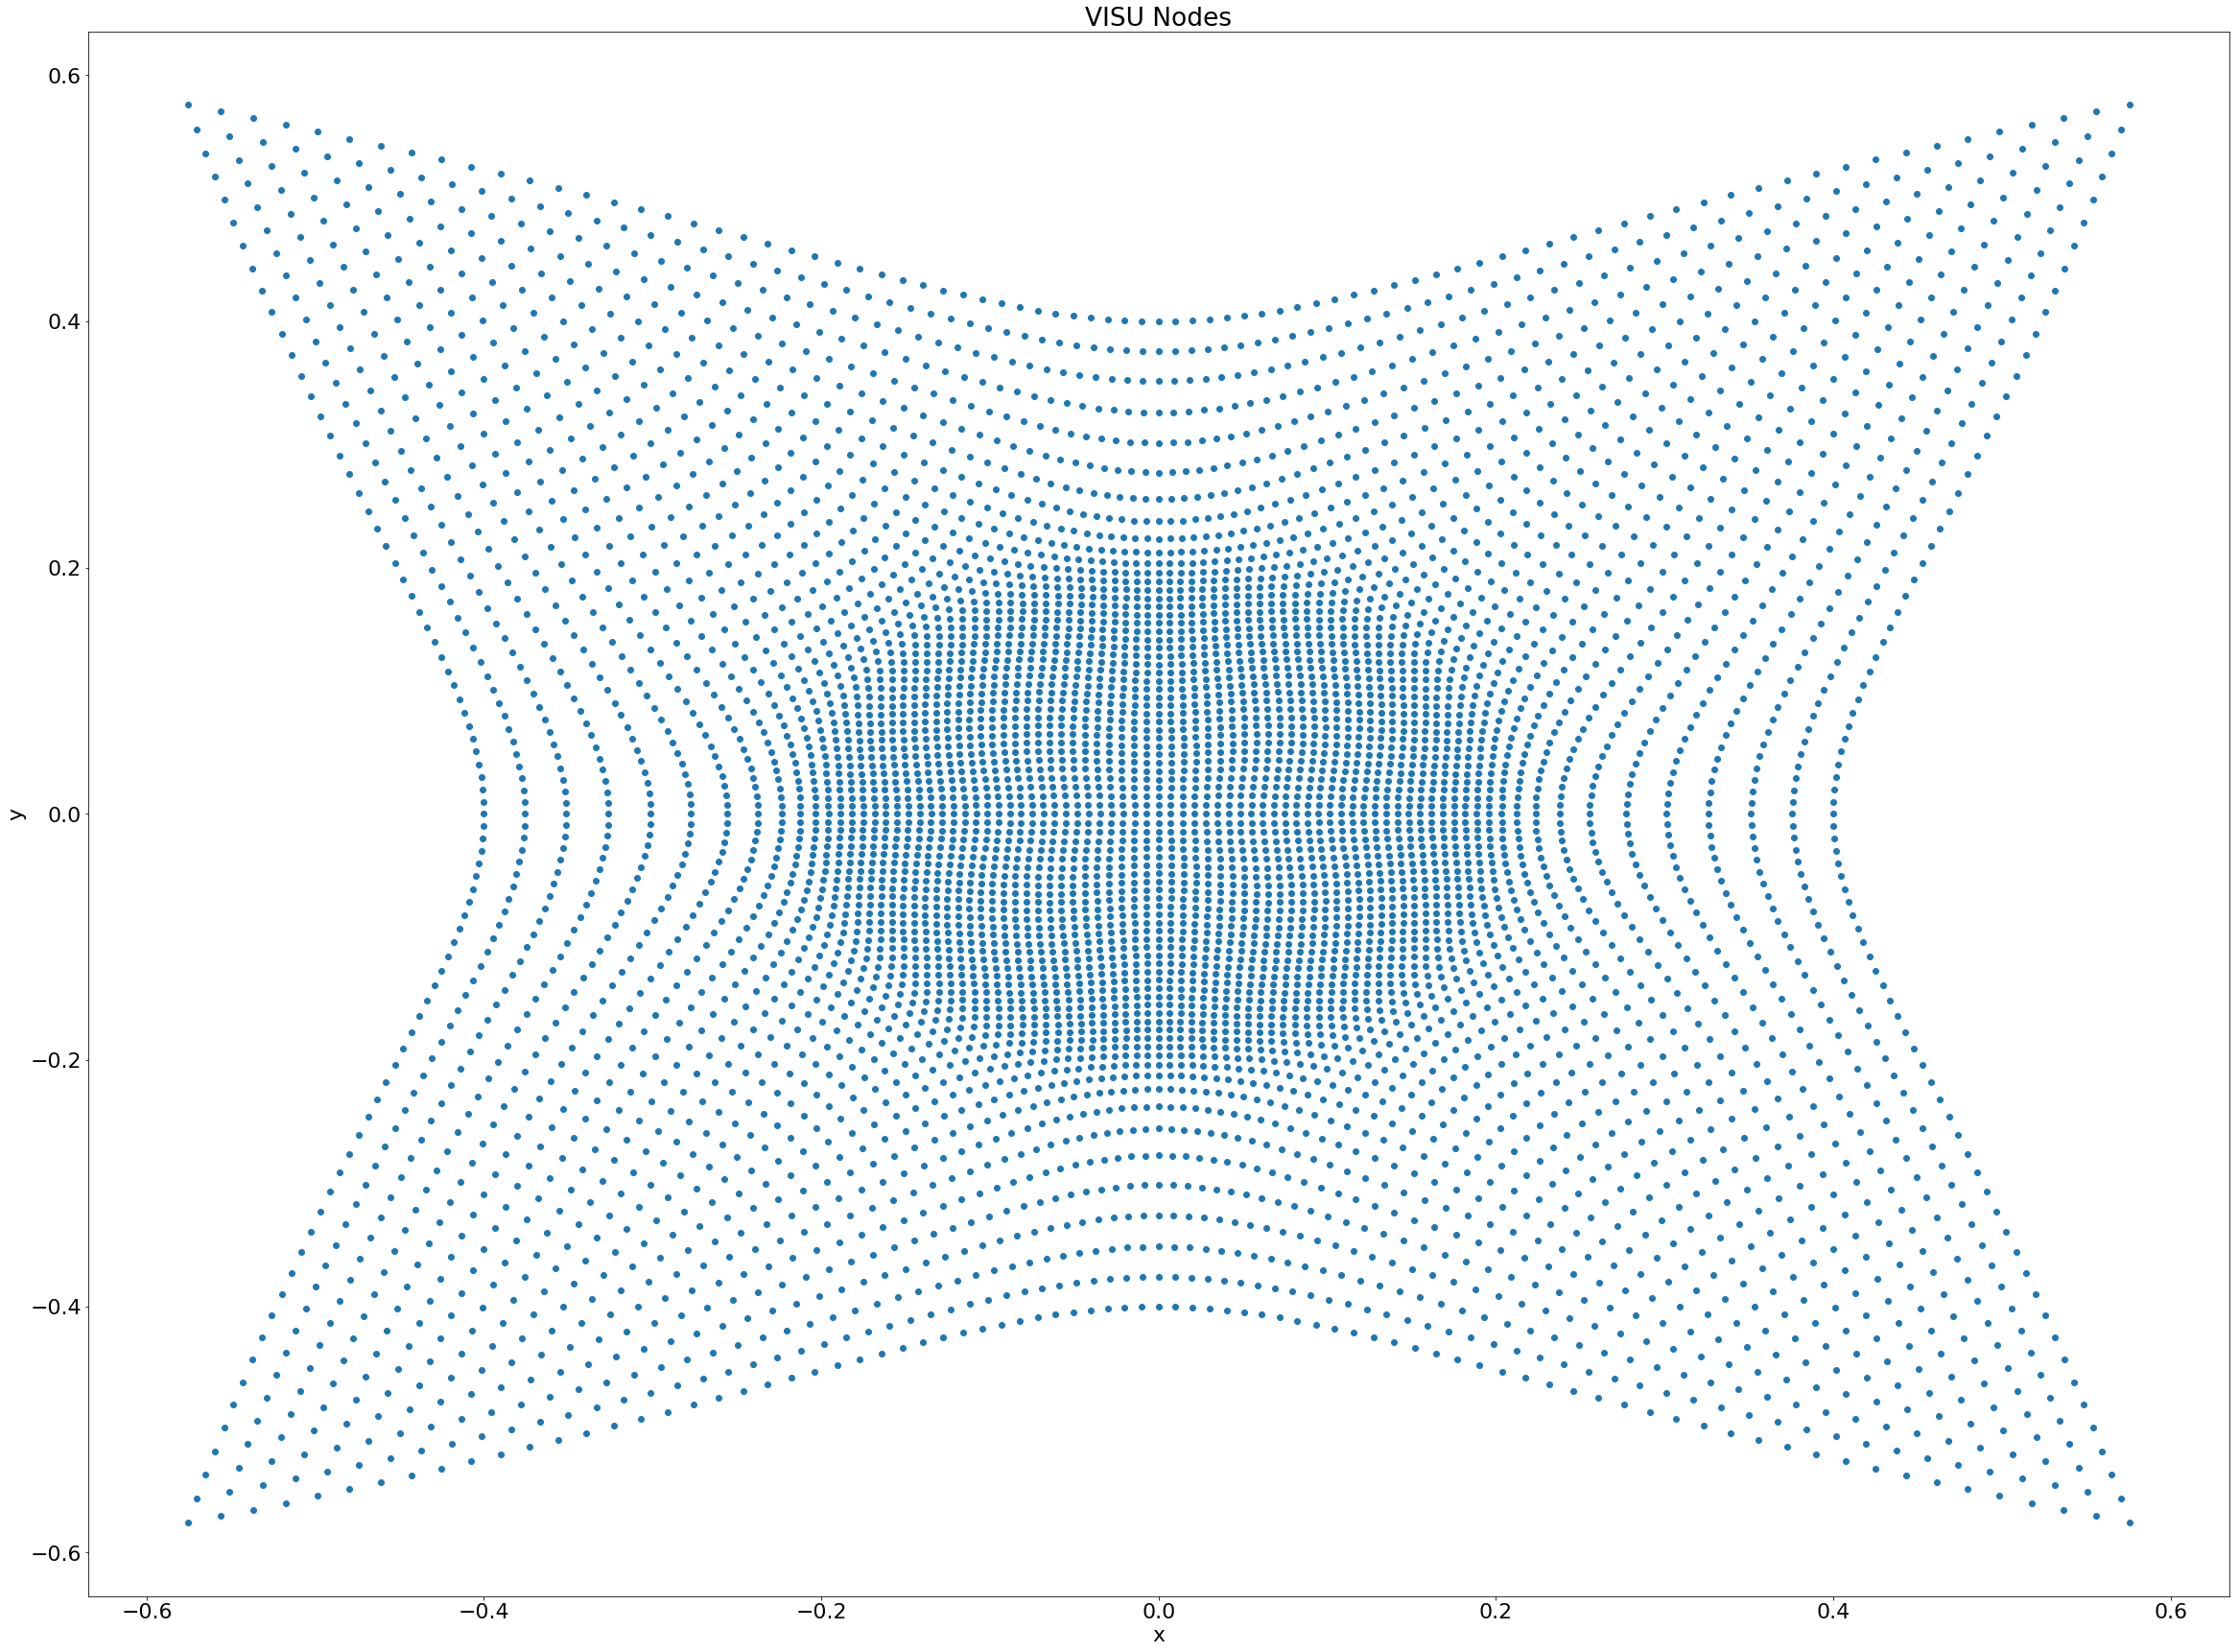

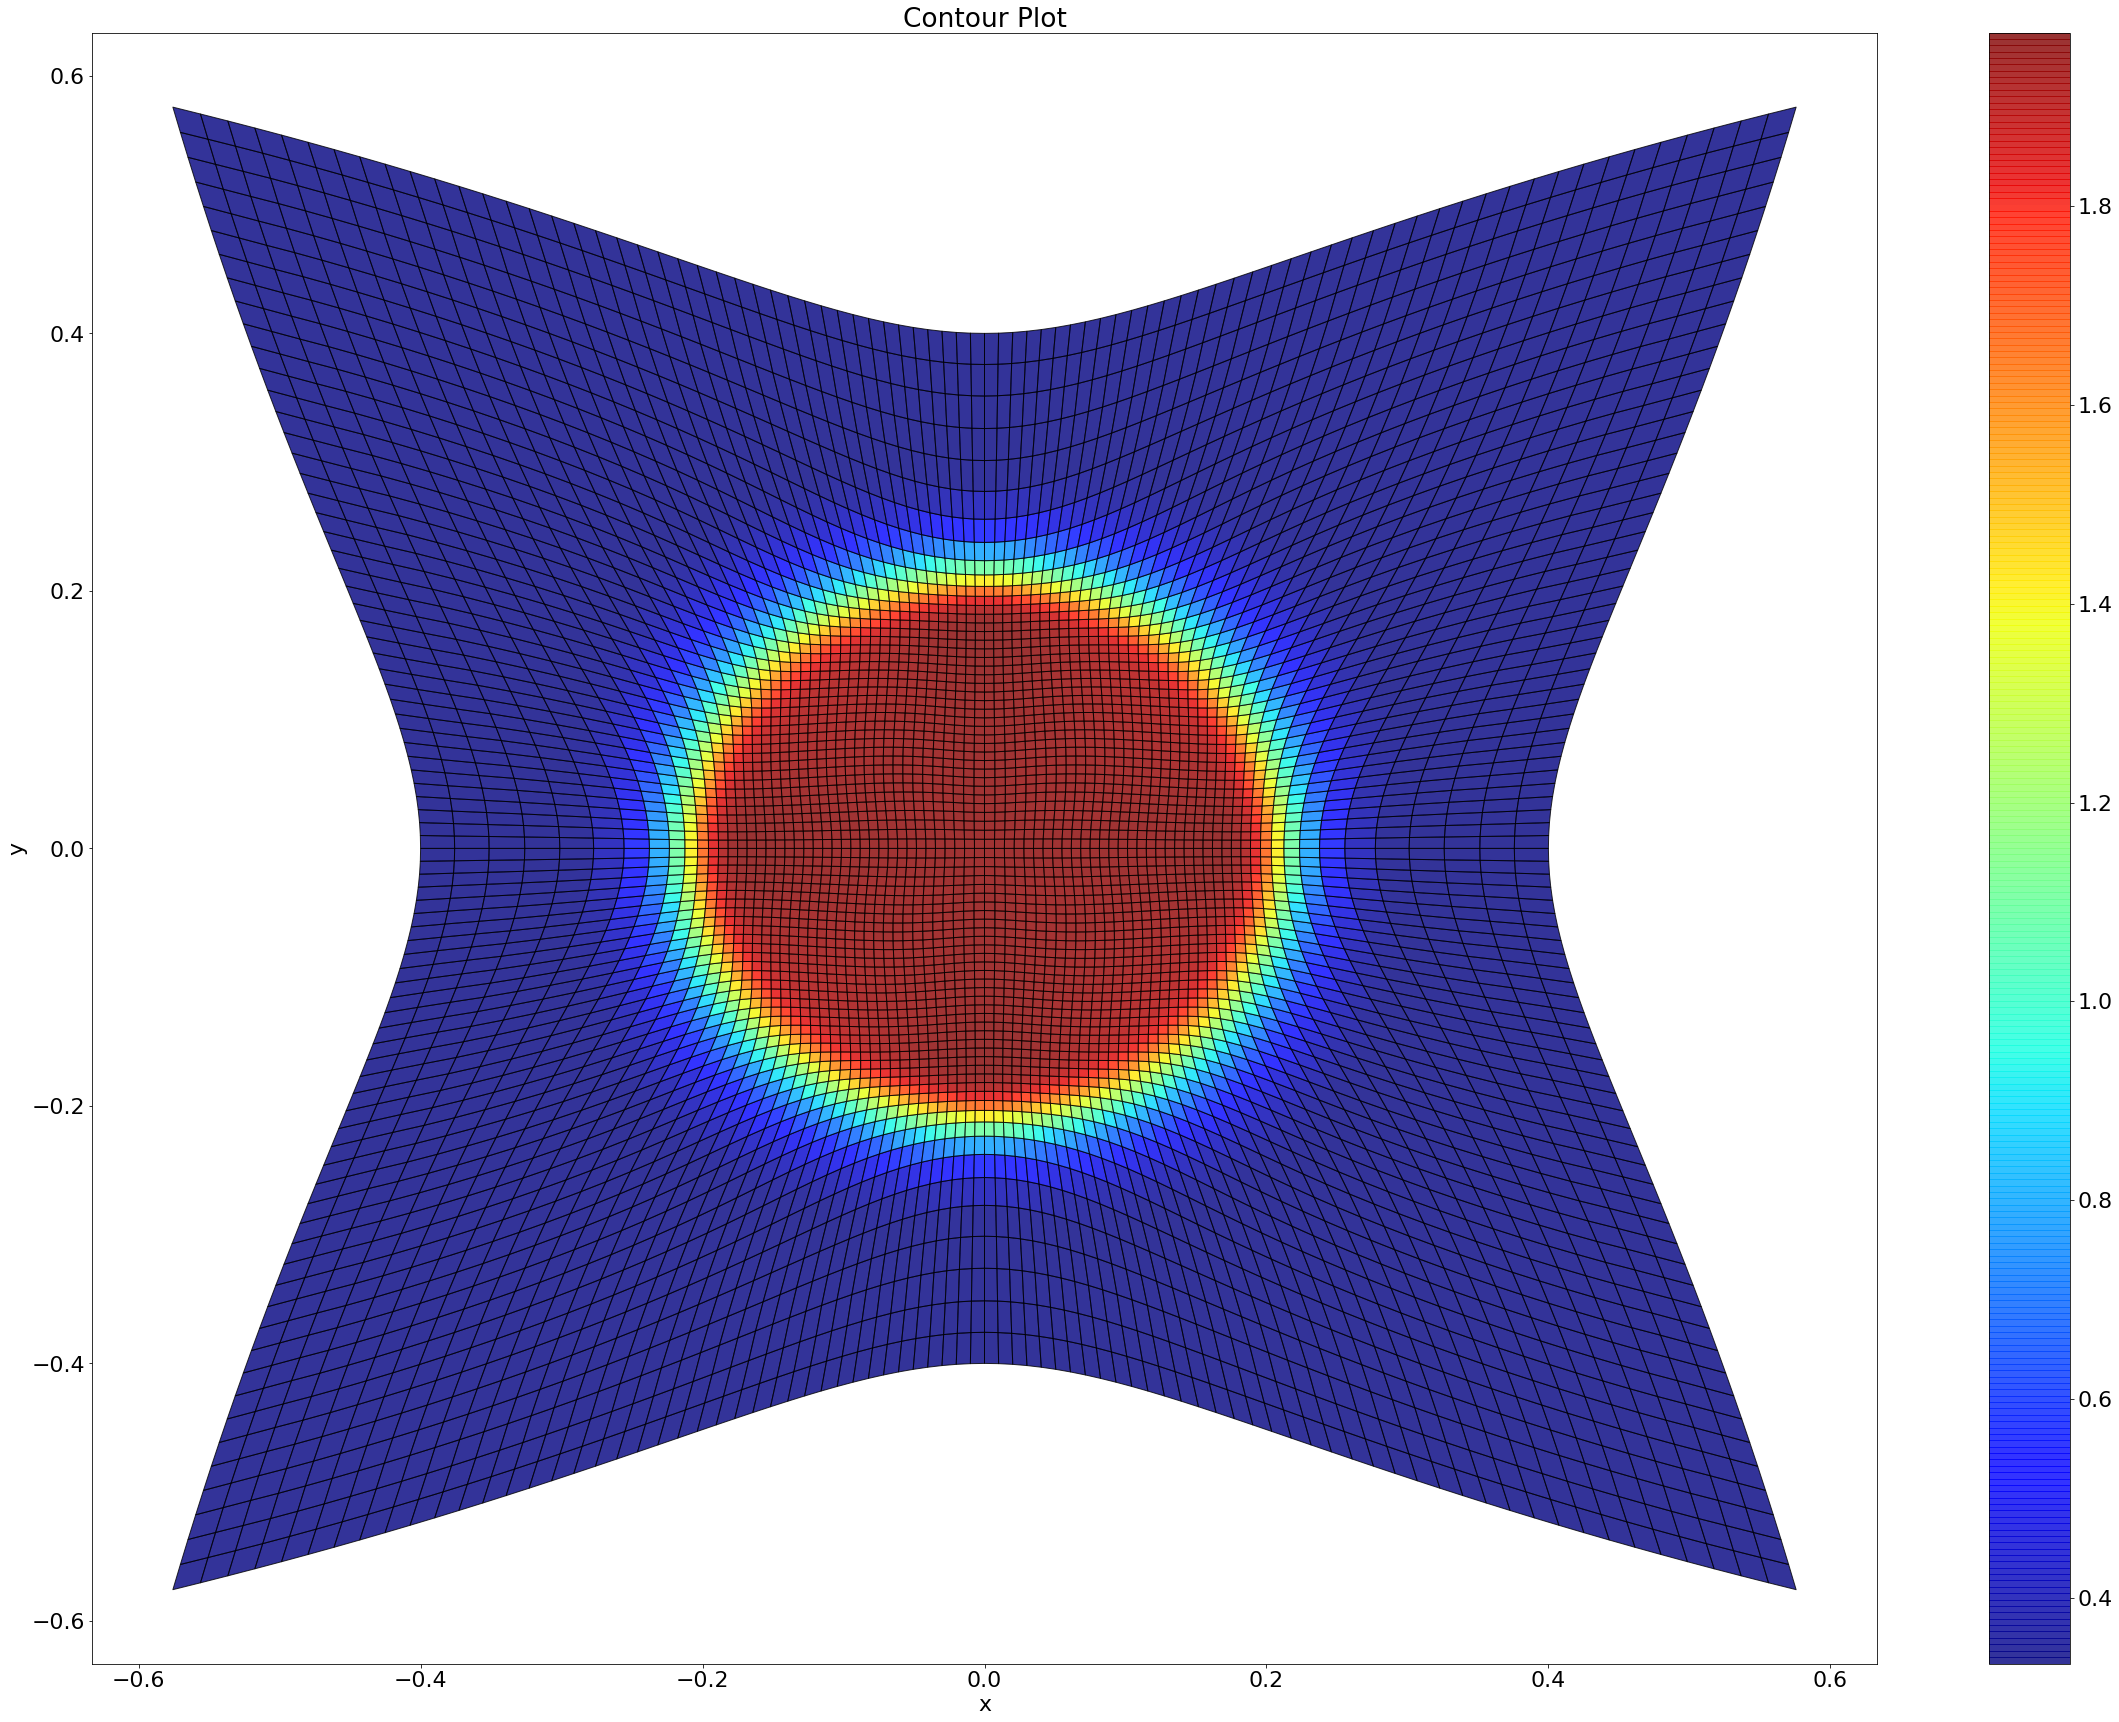

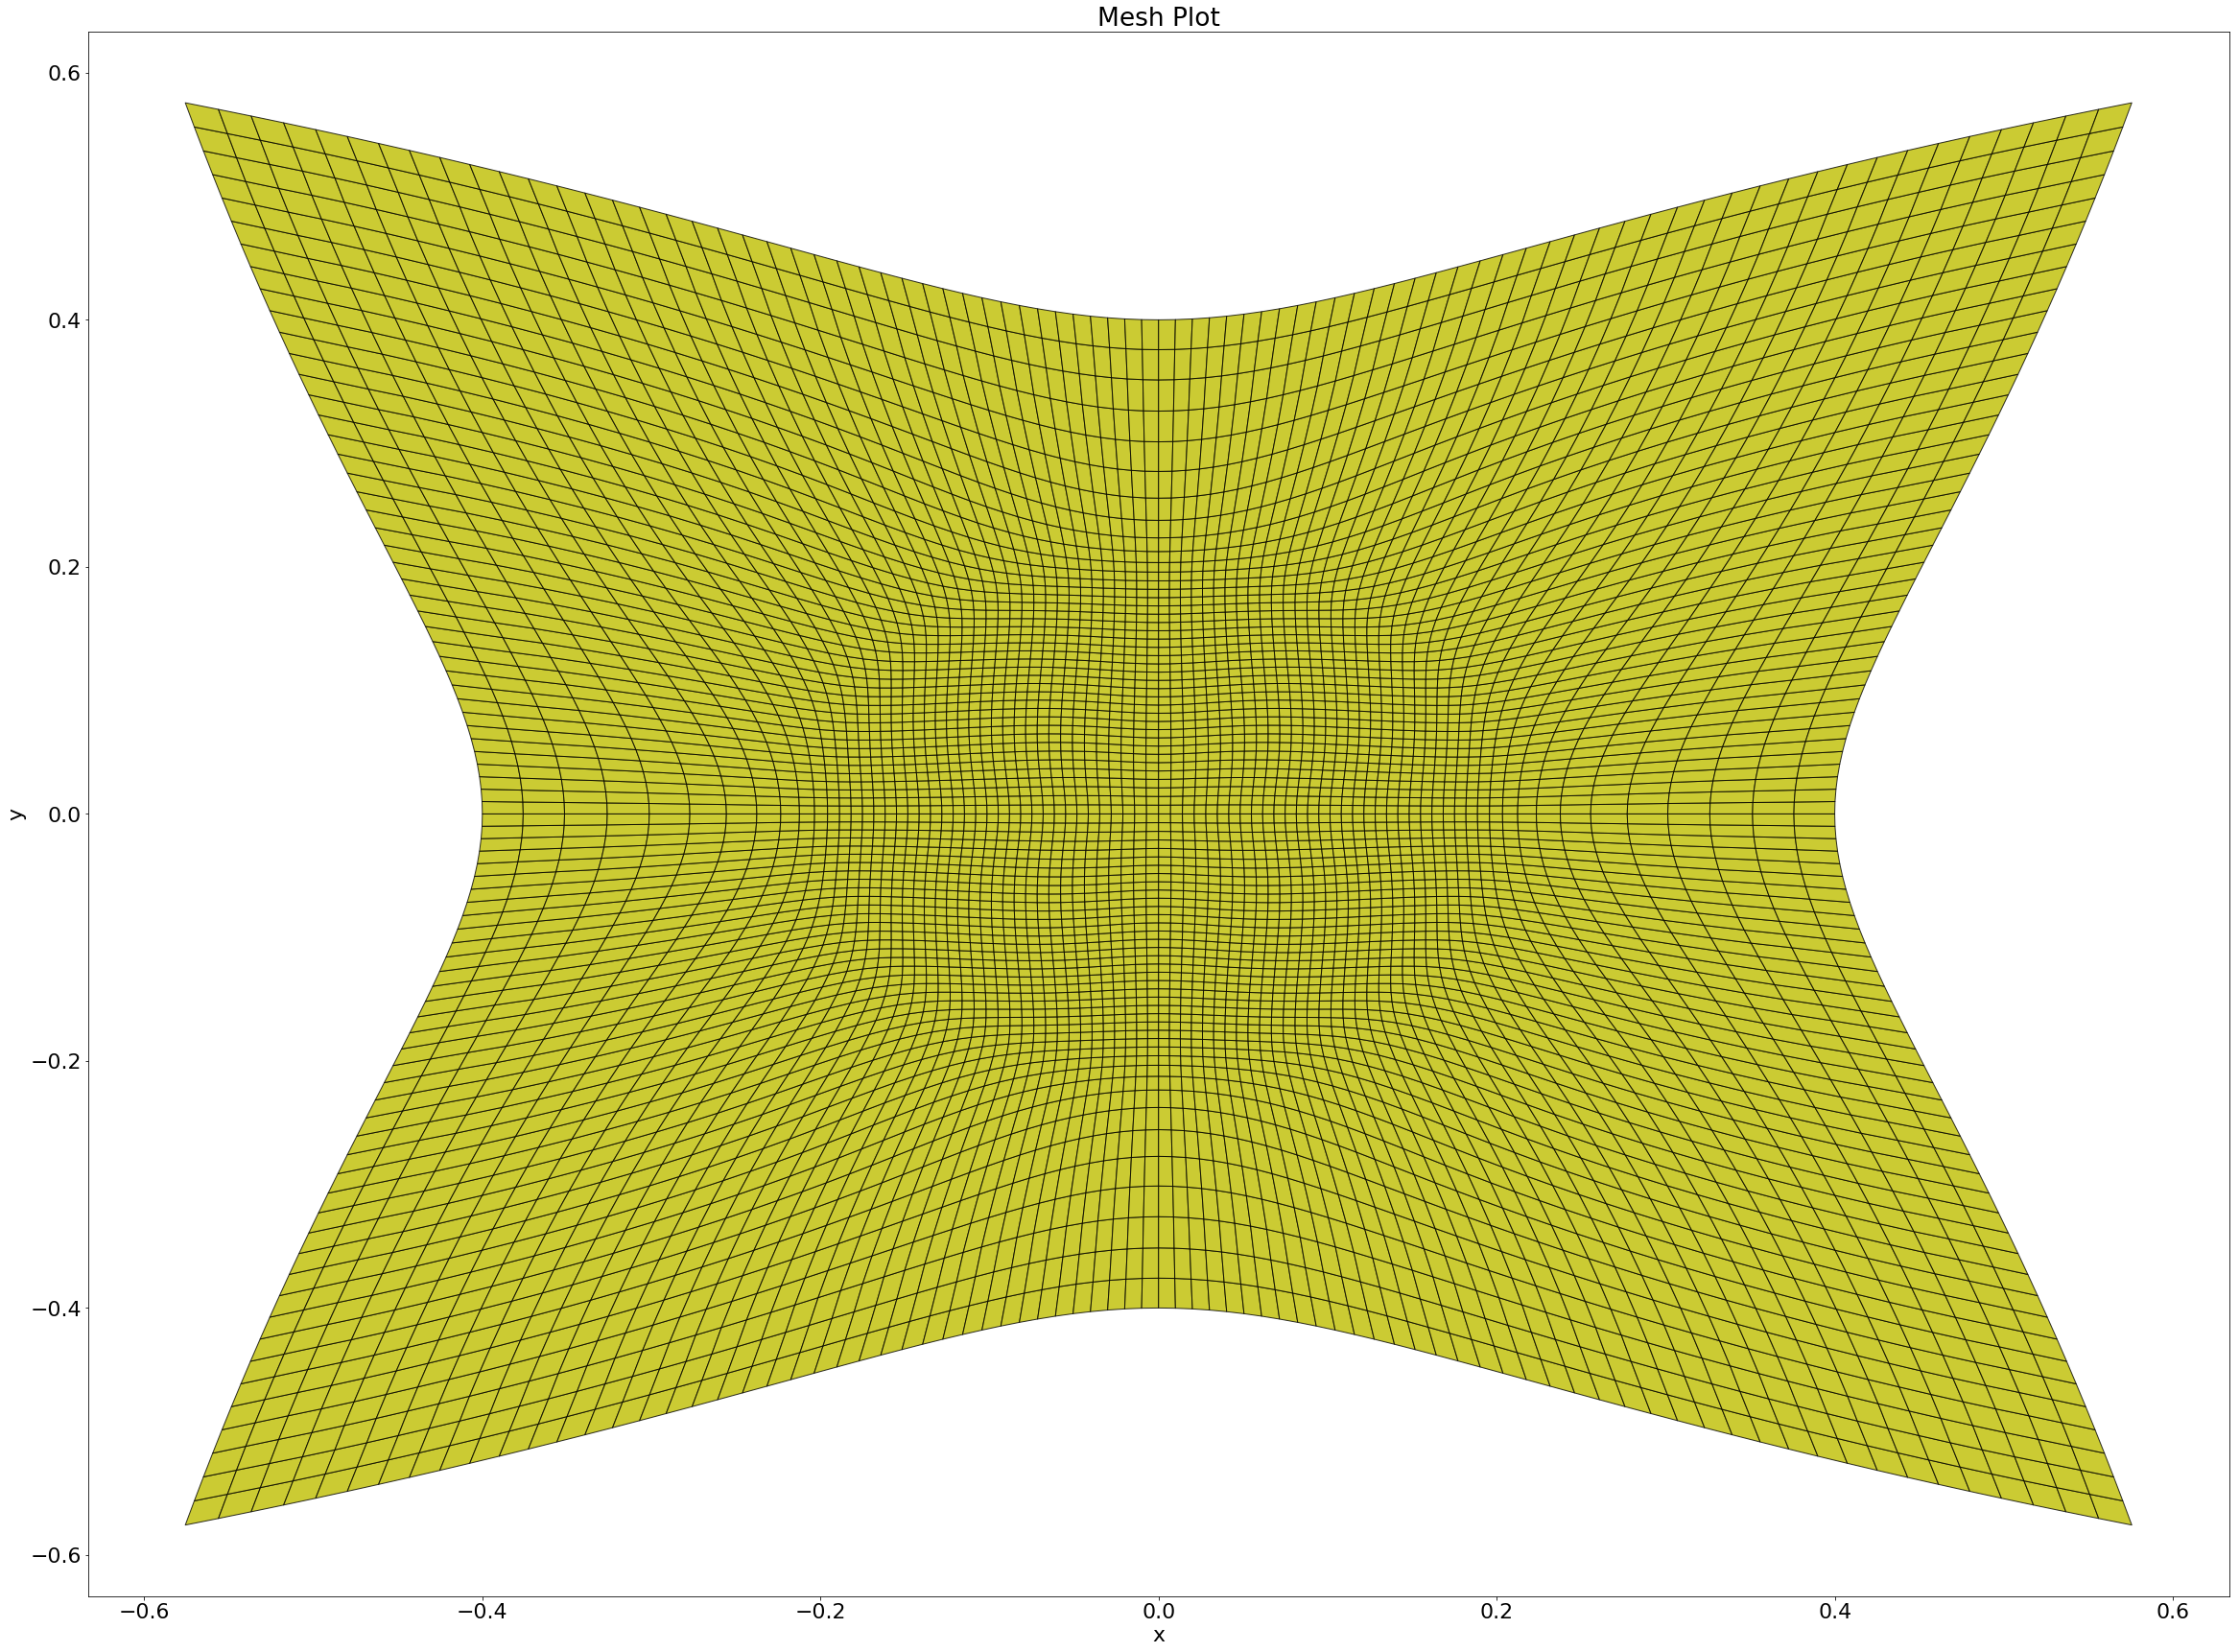

In [9]:
draw(r"/Users/Ivan/Desktop/Visu/noh8080_mesh.dat",
     r"/Users/Ivan/Desktop/Visu/input_cellsid_noh8080.dat",
     r"/Users/Ivan/Desktop/Visu/input_cnconn_noh8080.dat",
     r"/Users/Ivan/Desktop/Visu/noh8080_vals.dat",
     'crho')

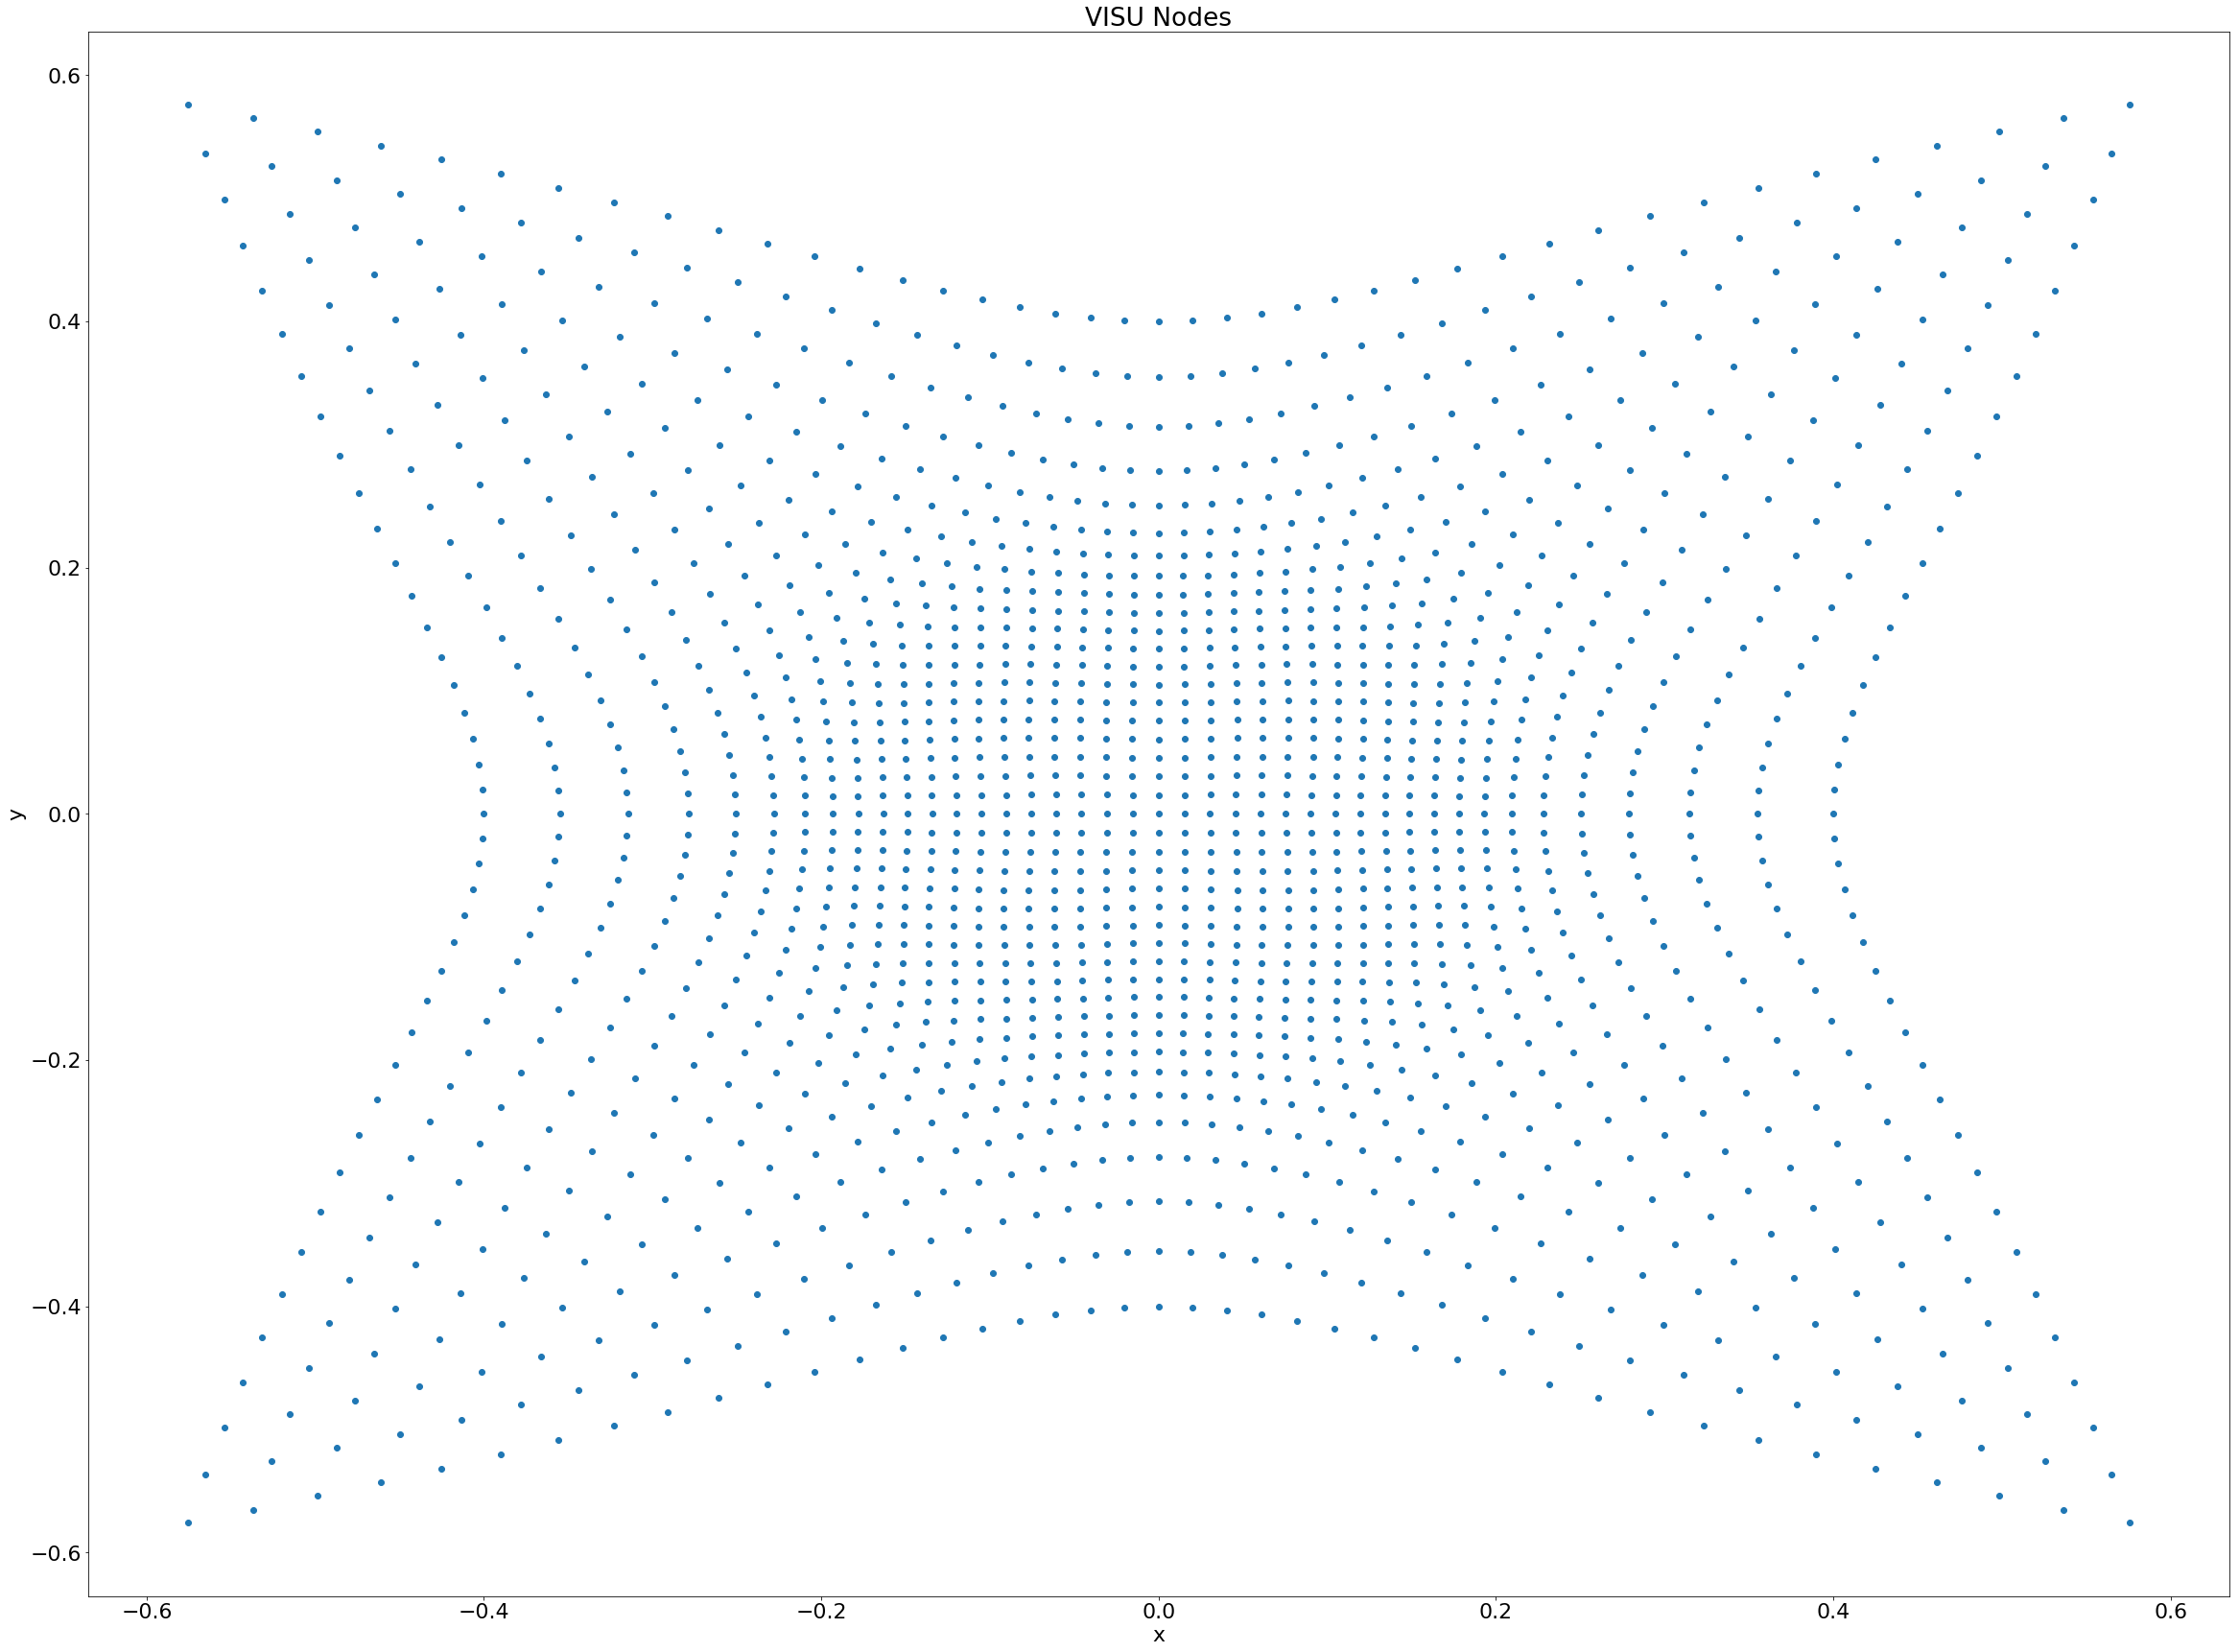

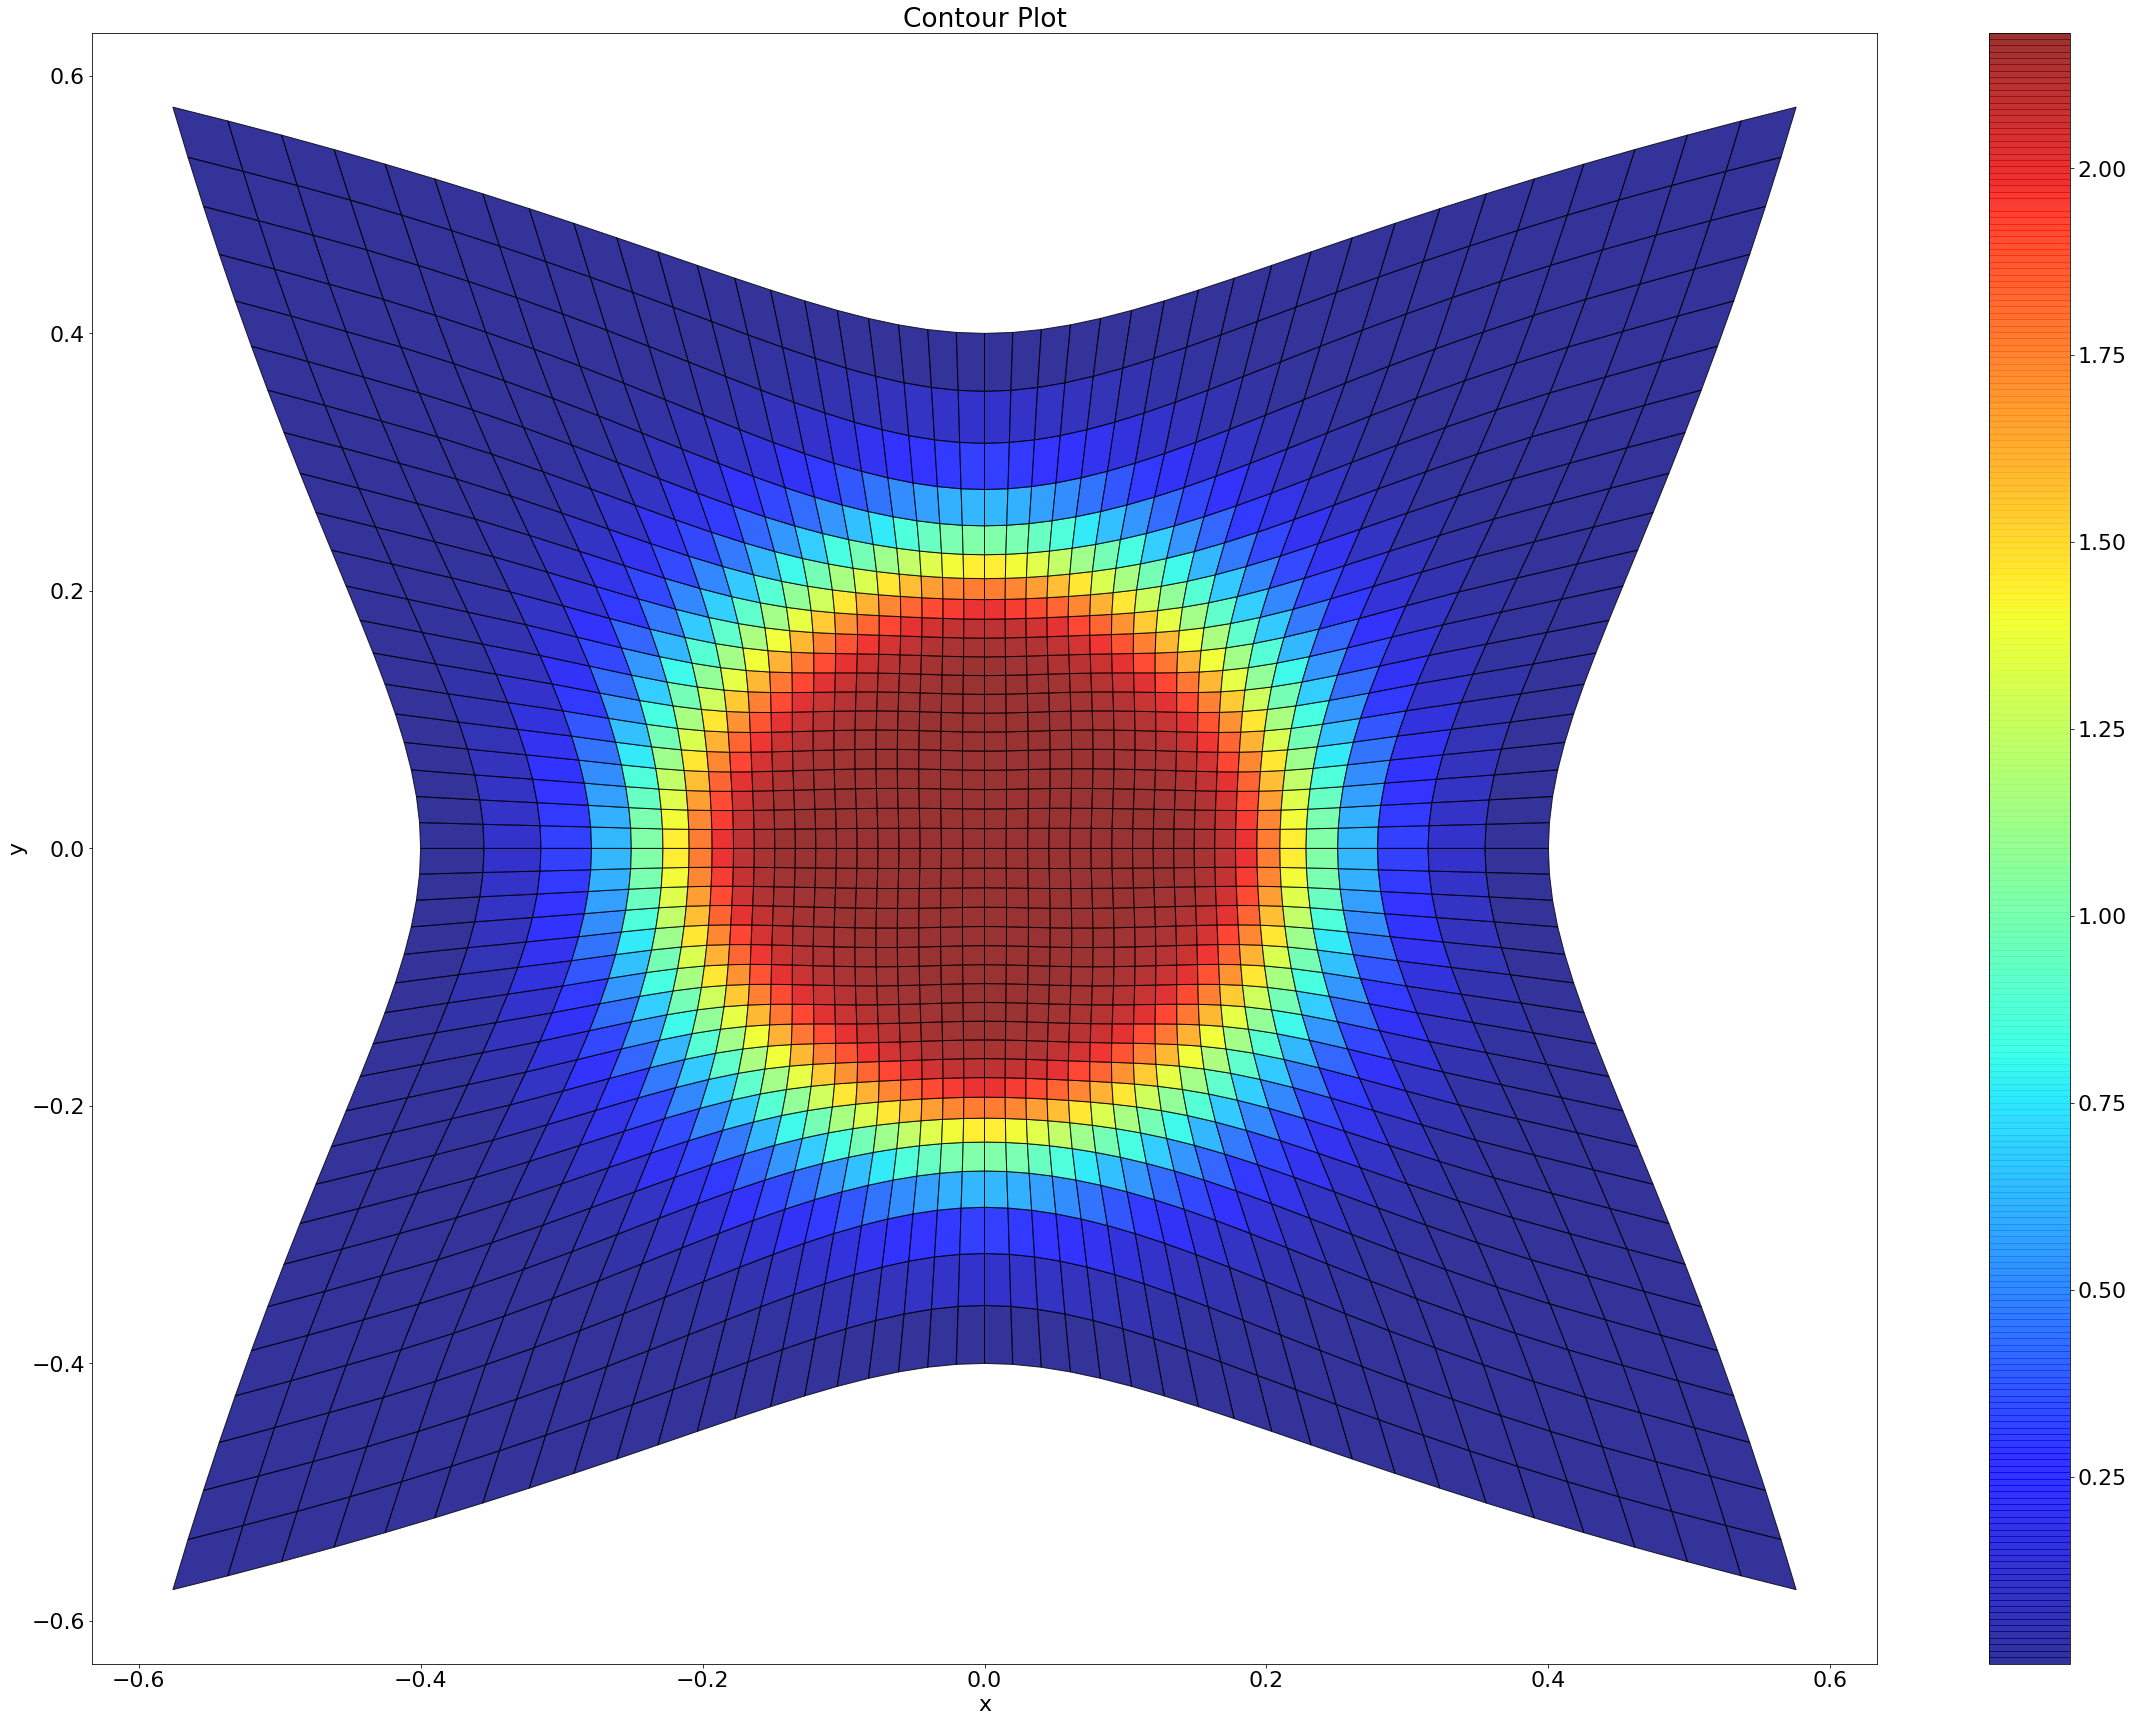

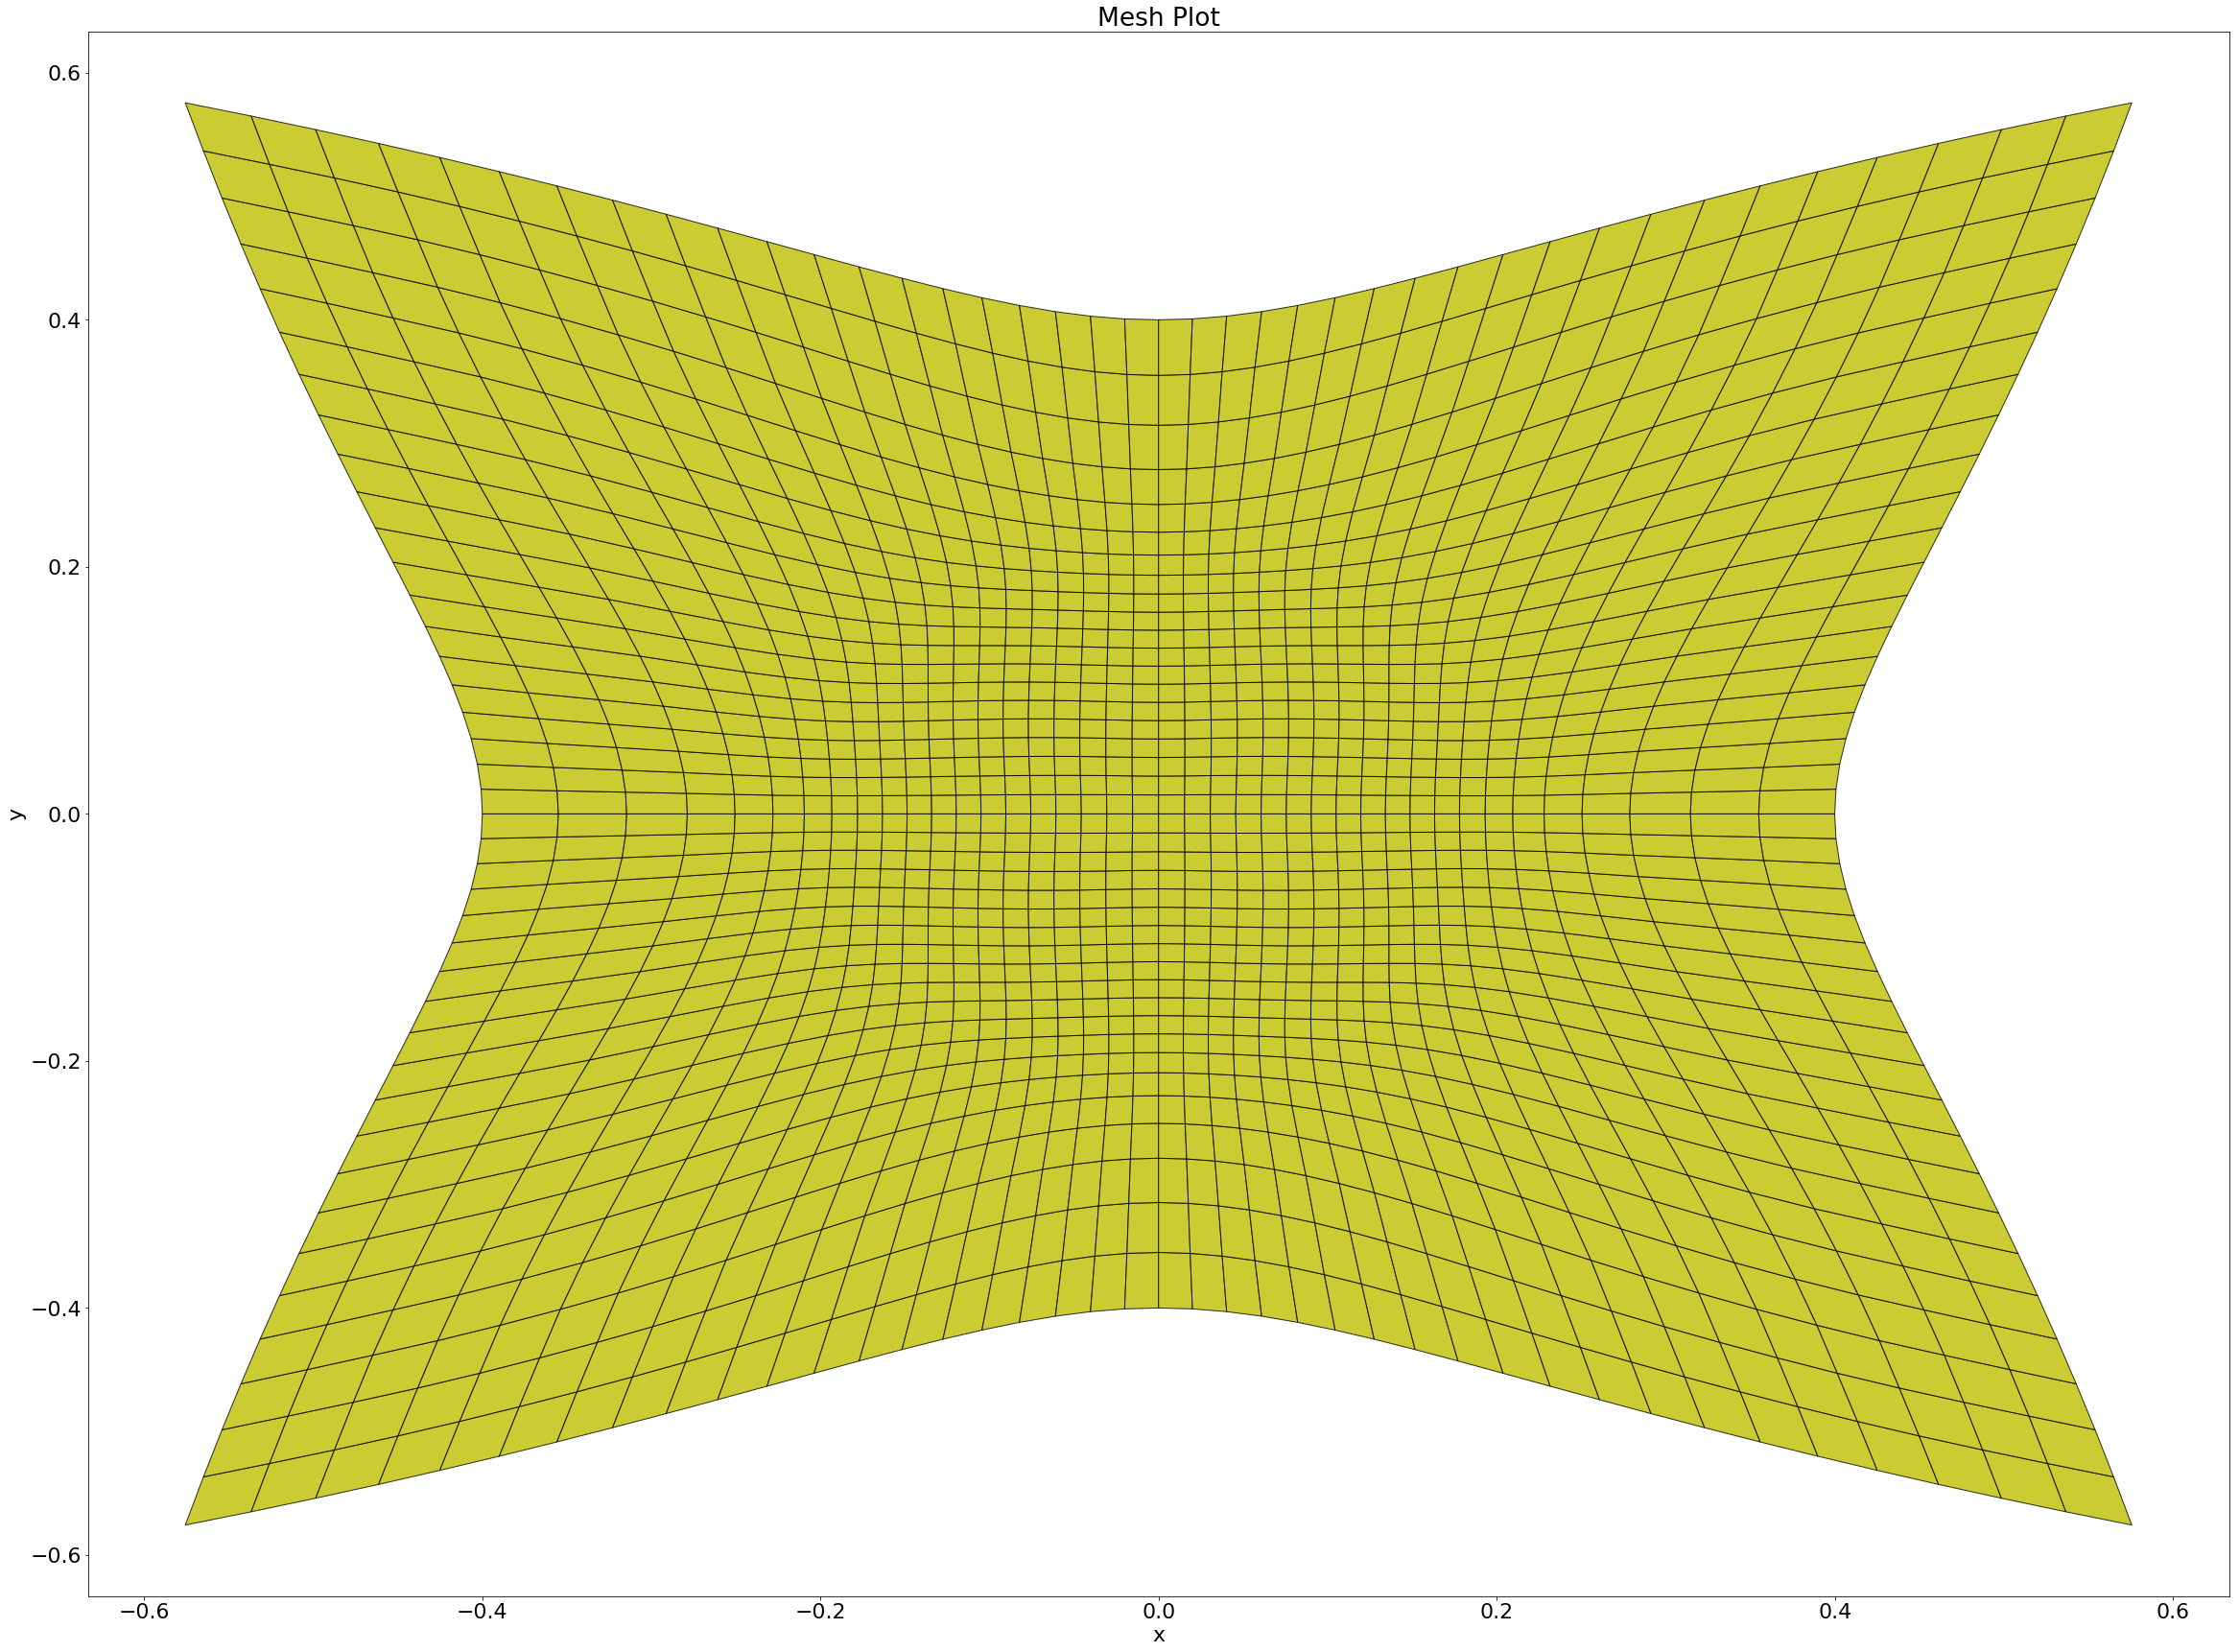

In [7]:
draw(r"/Users/Ivan/Desktop/Visu/noh4040_mesh.dat",
     r"/Users/Ivan/Desktop/Visu/input_cellsid_noh4040.dat",
     r"/Users/Ivan/Desktop/Visu/input_cnconn_noh4040.dat",
     r"/Users/Ivan/Desktop/Visu/noh4040_vals.dat",
     'crho')

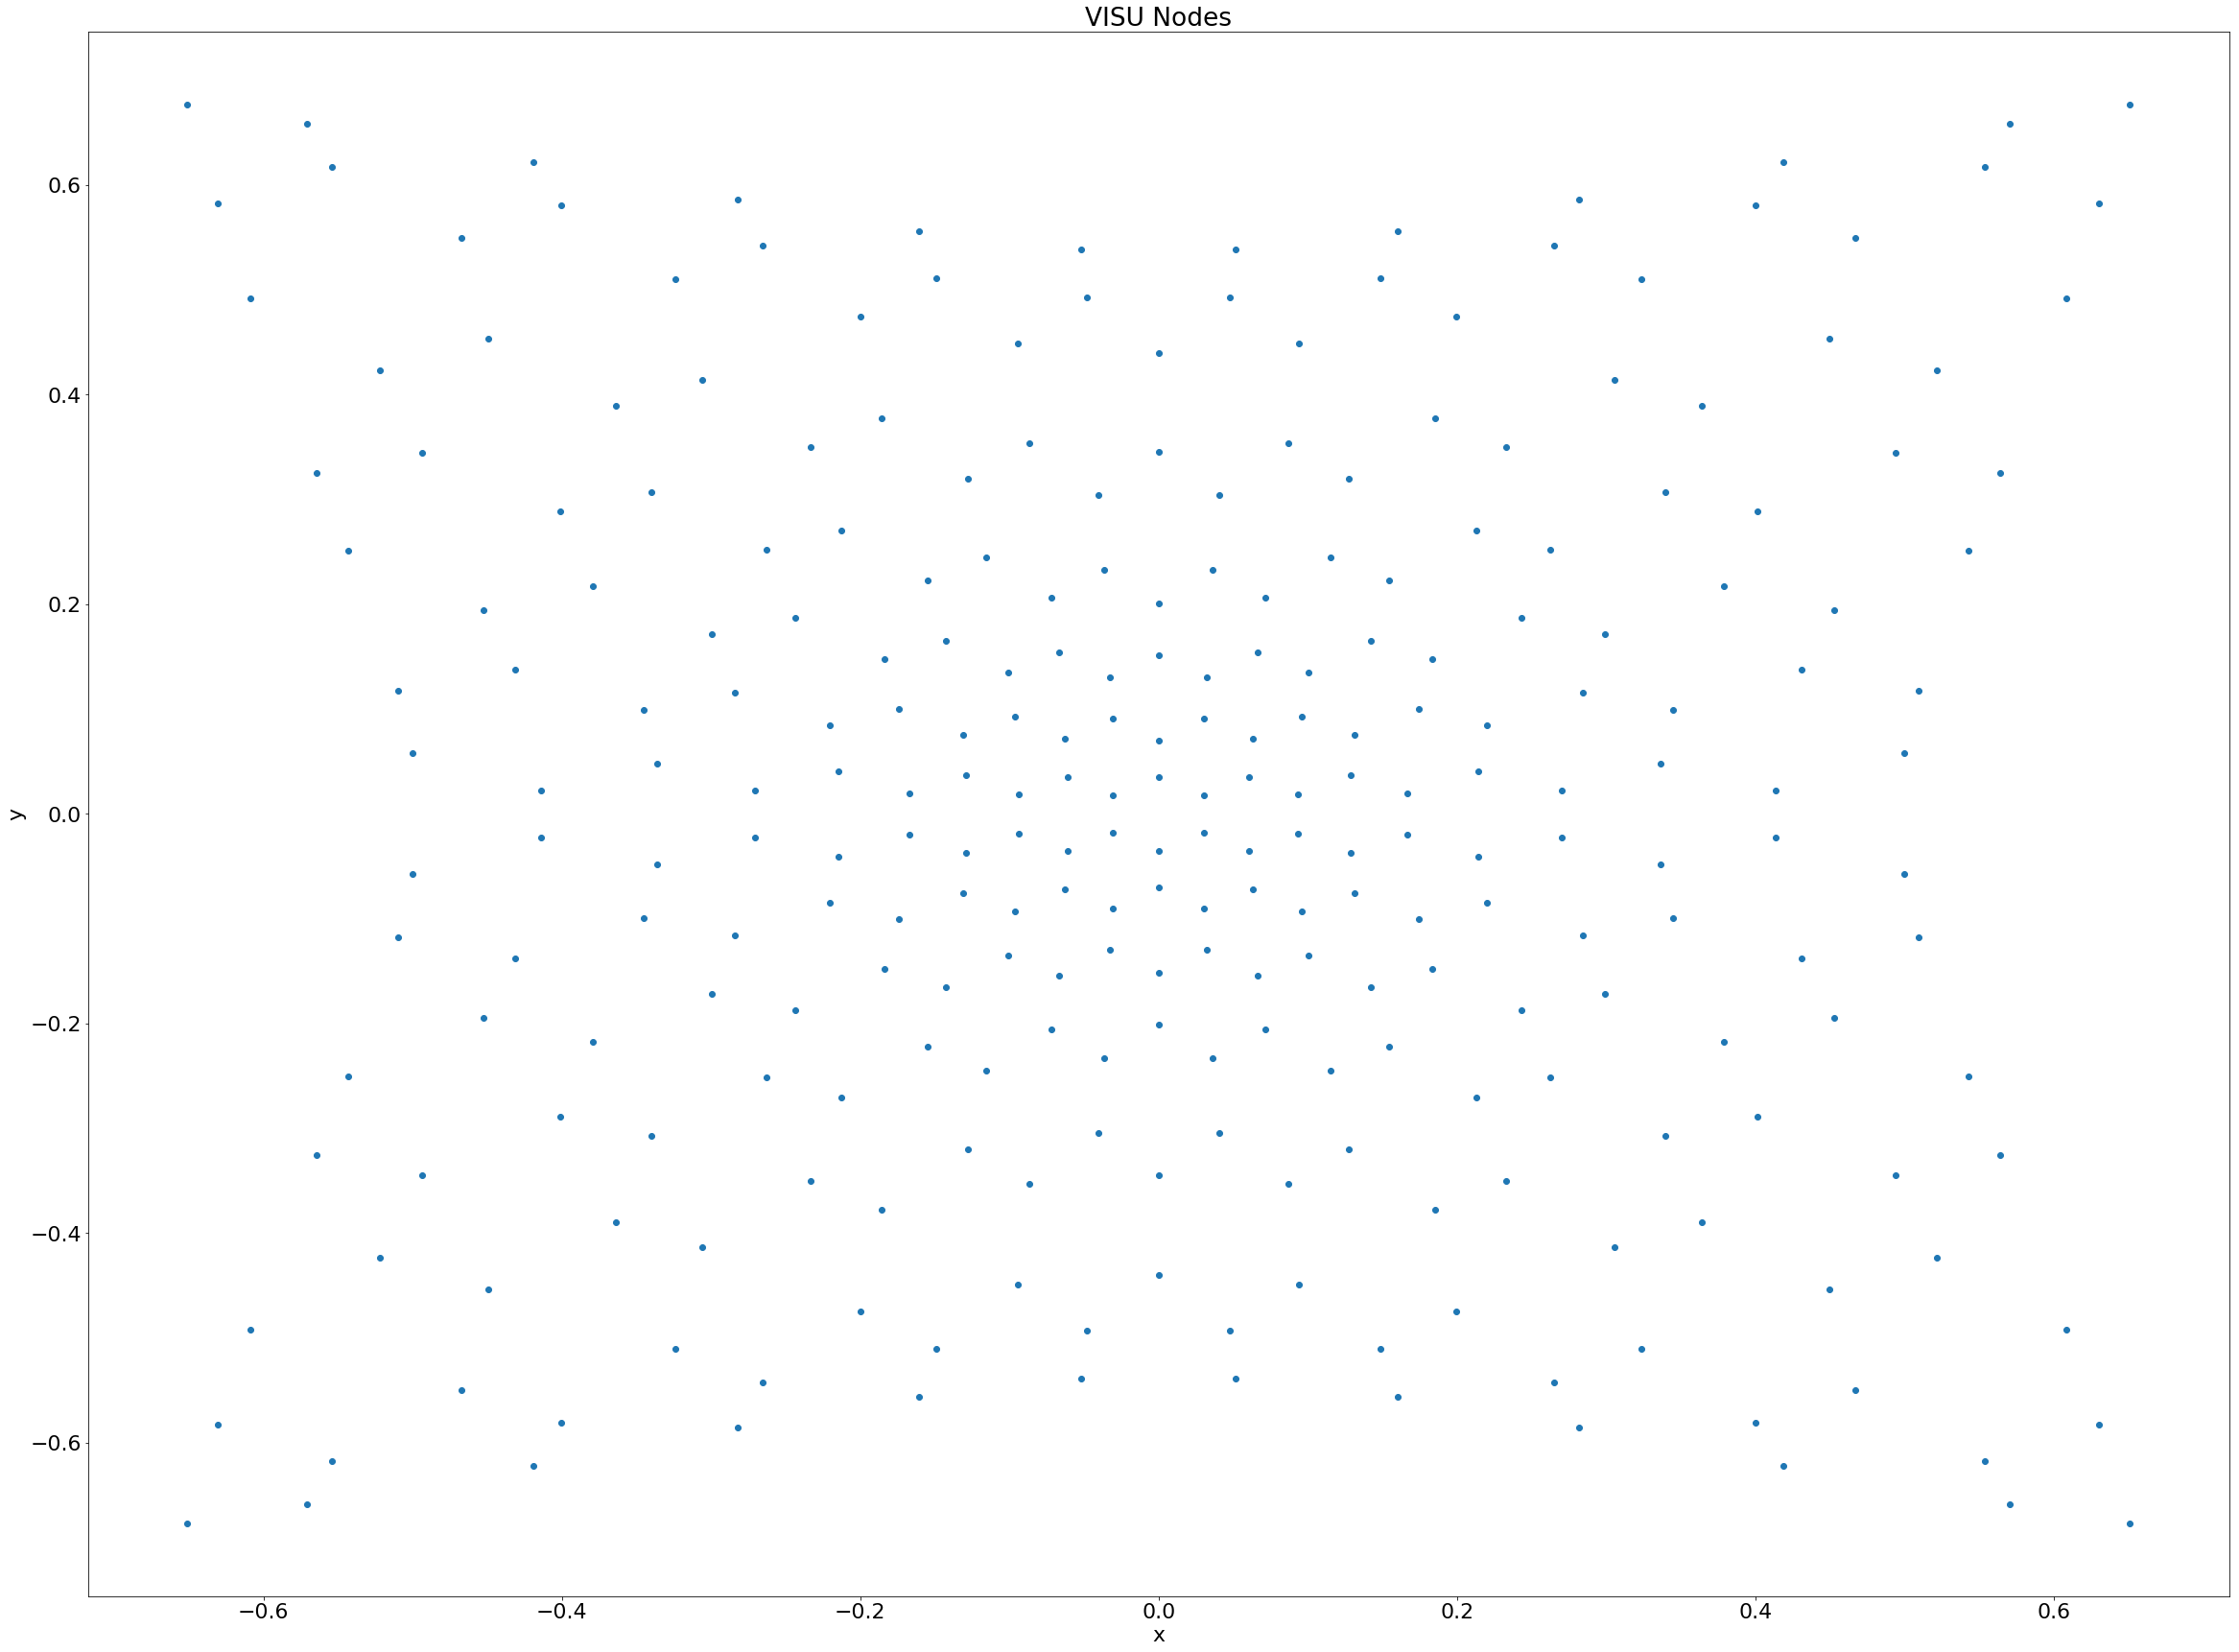

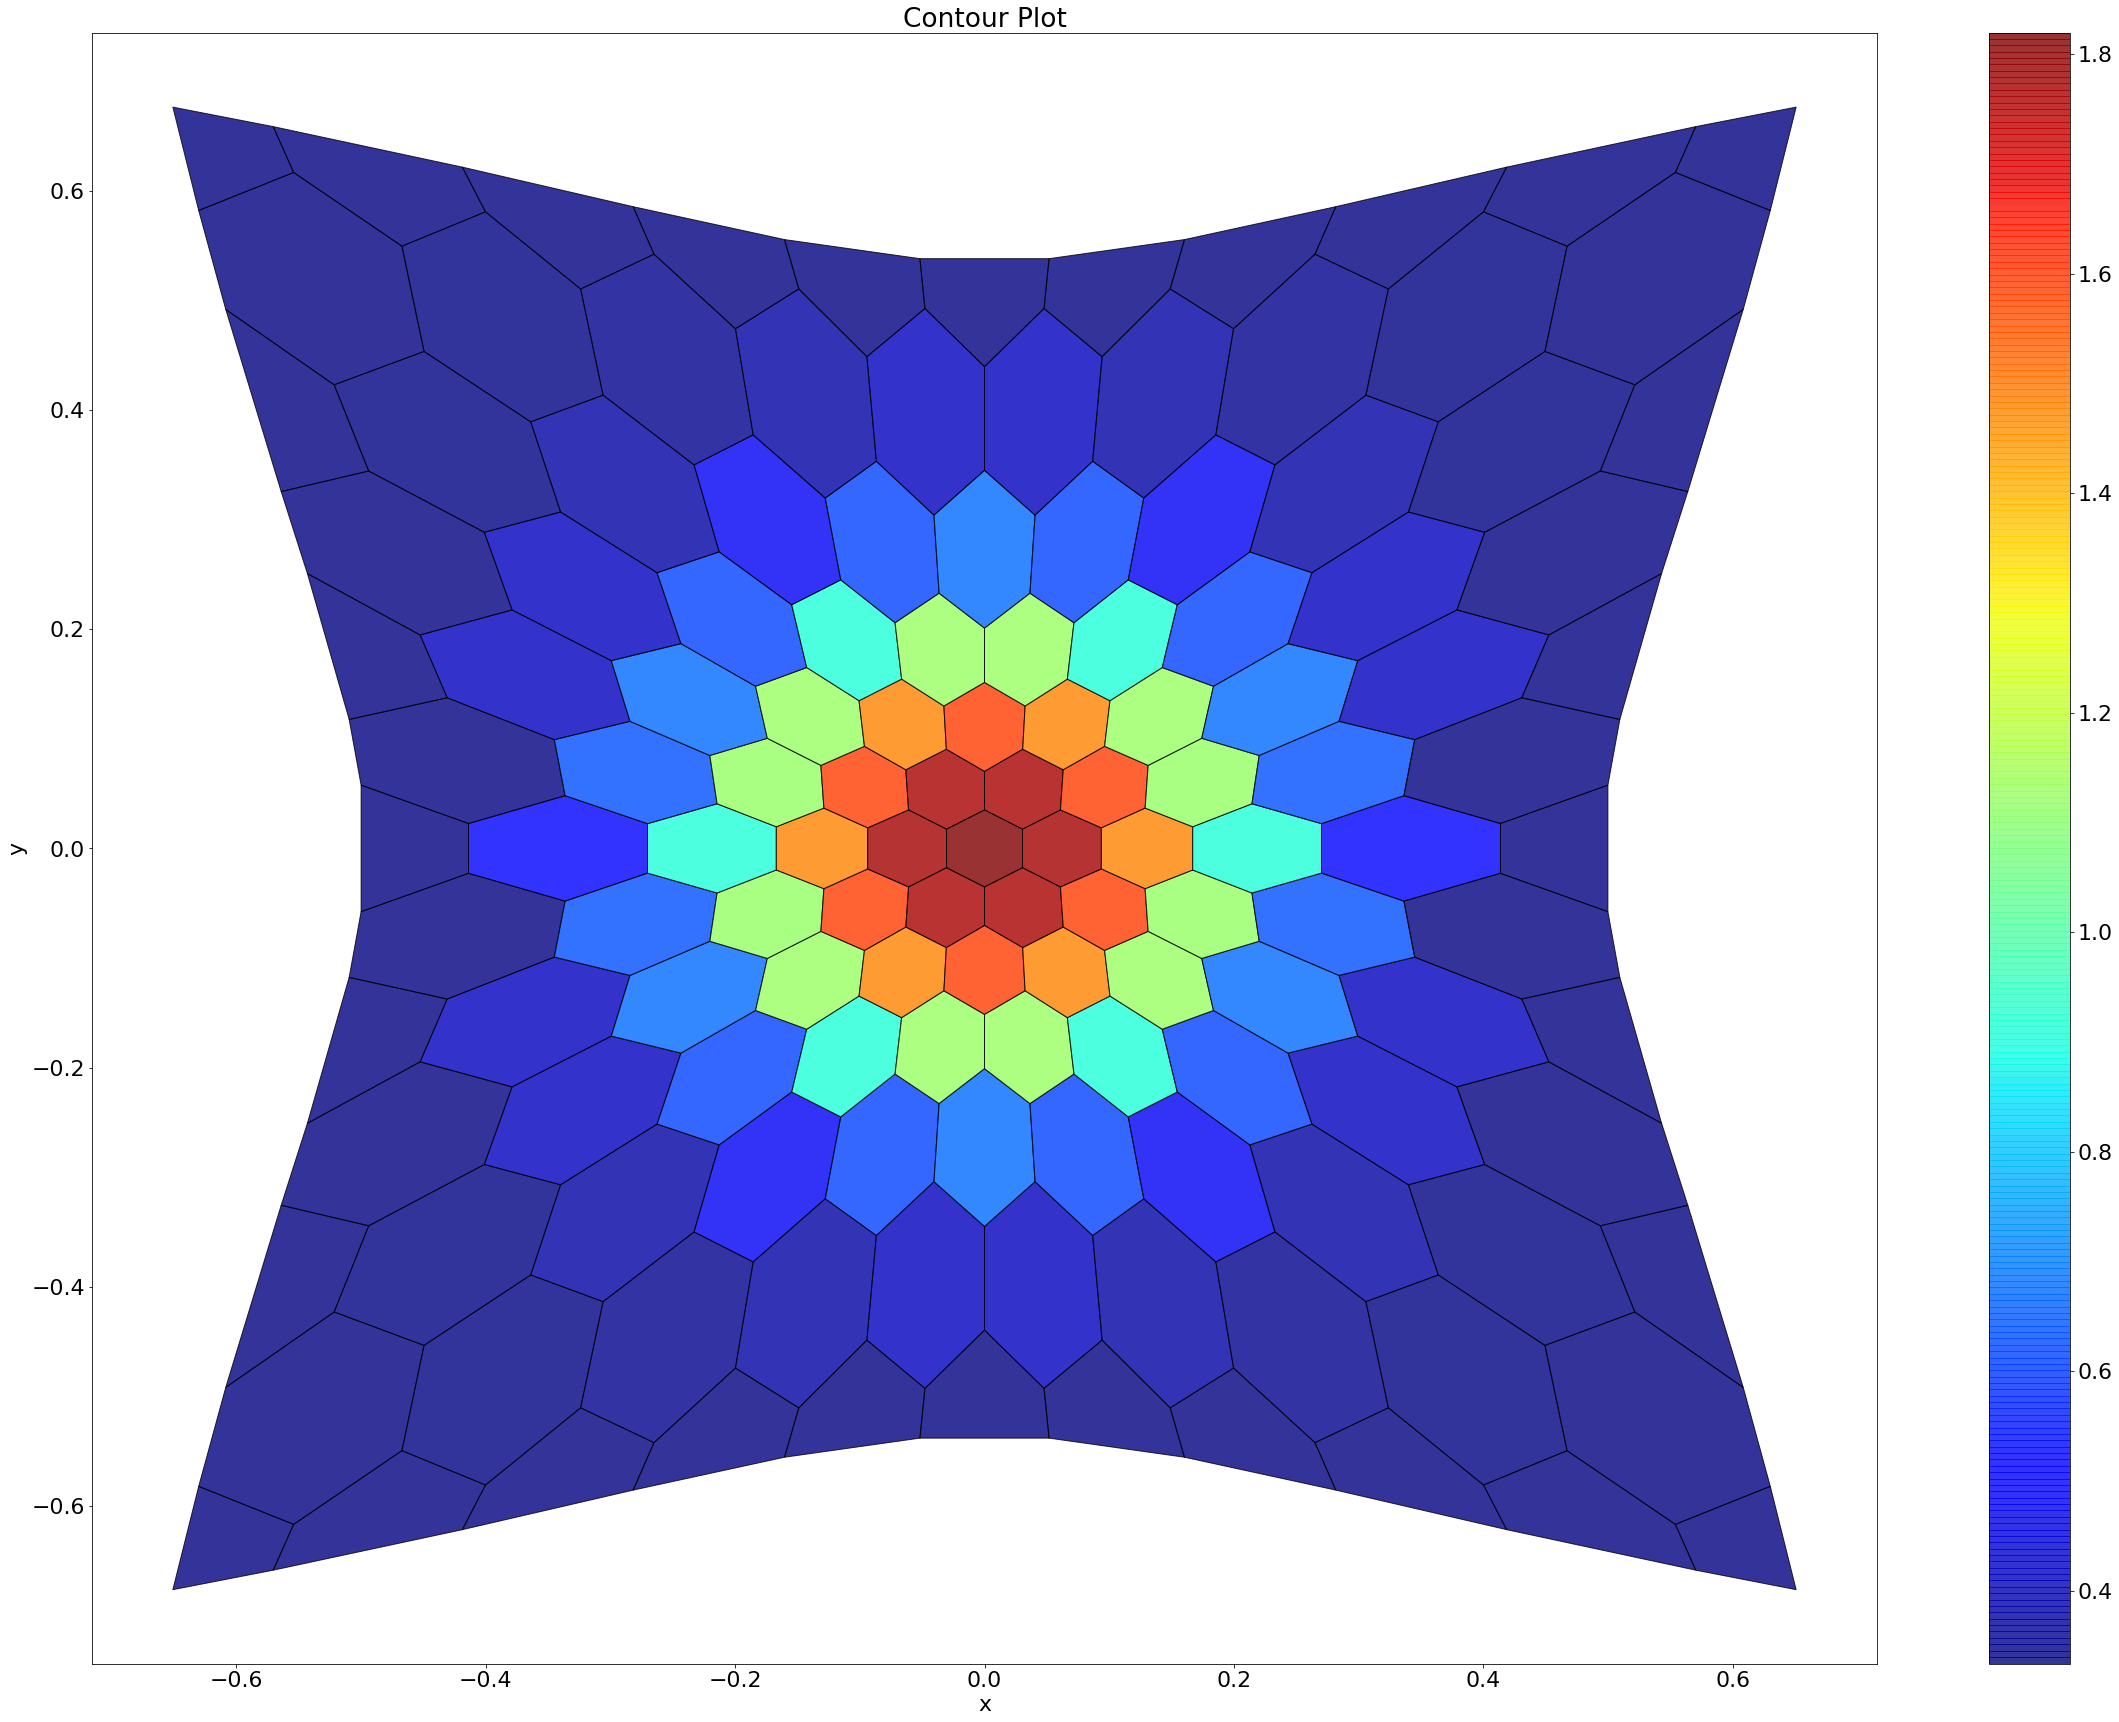

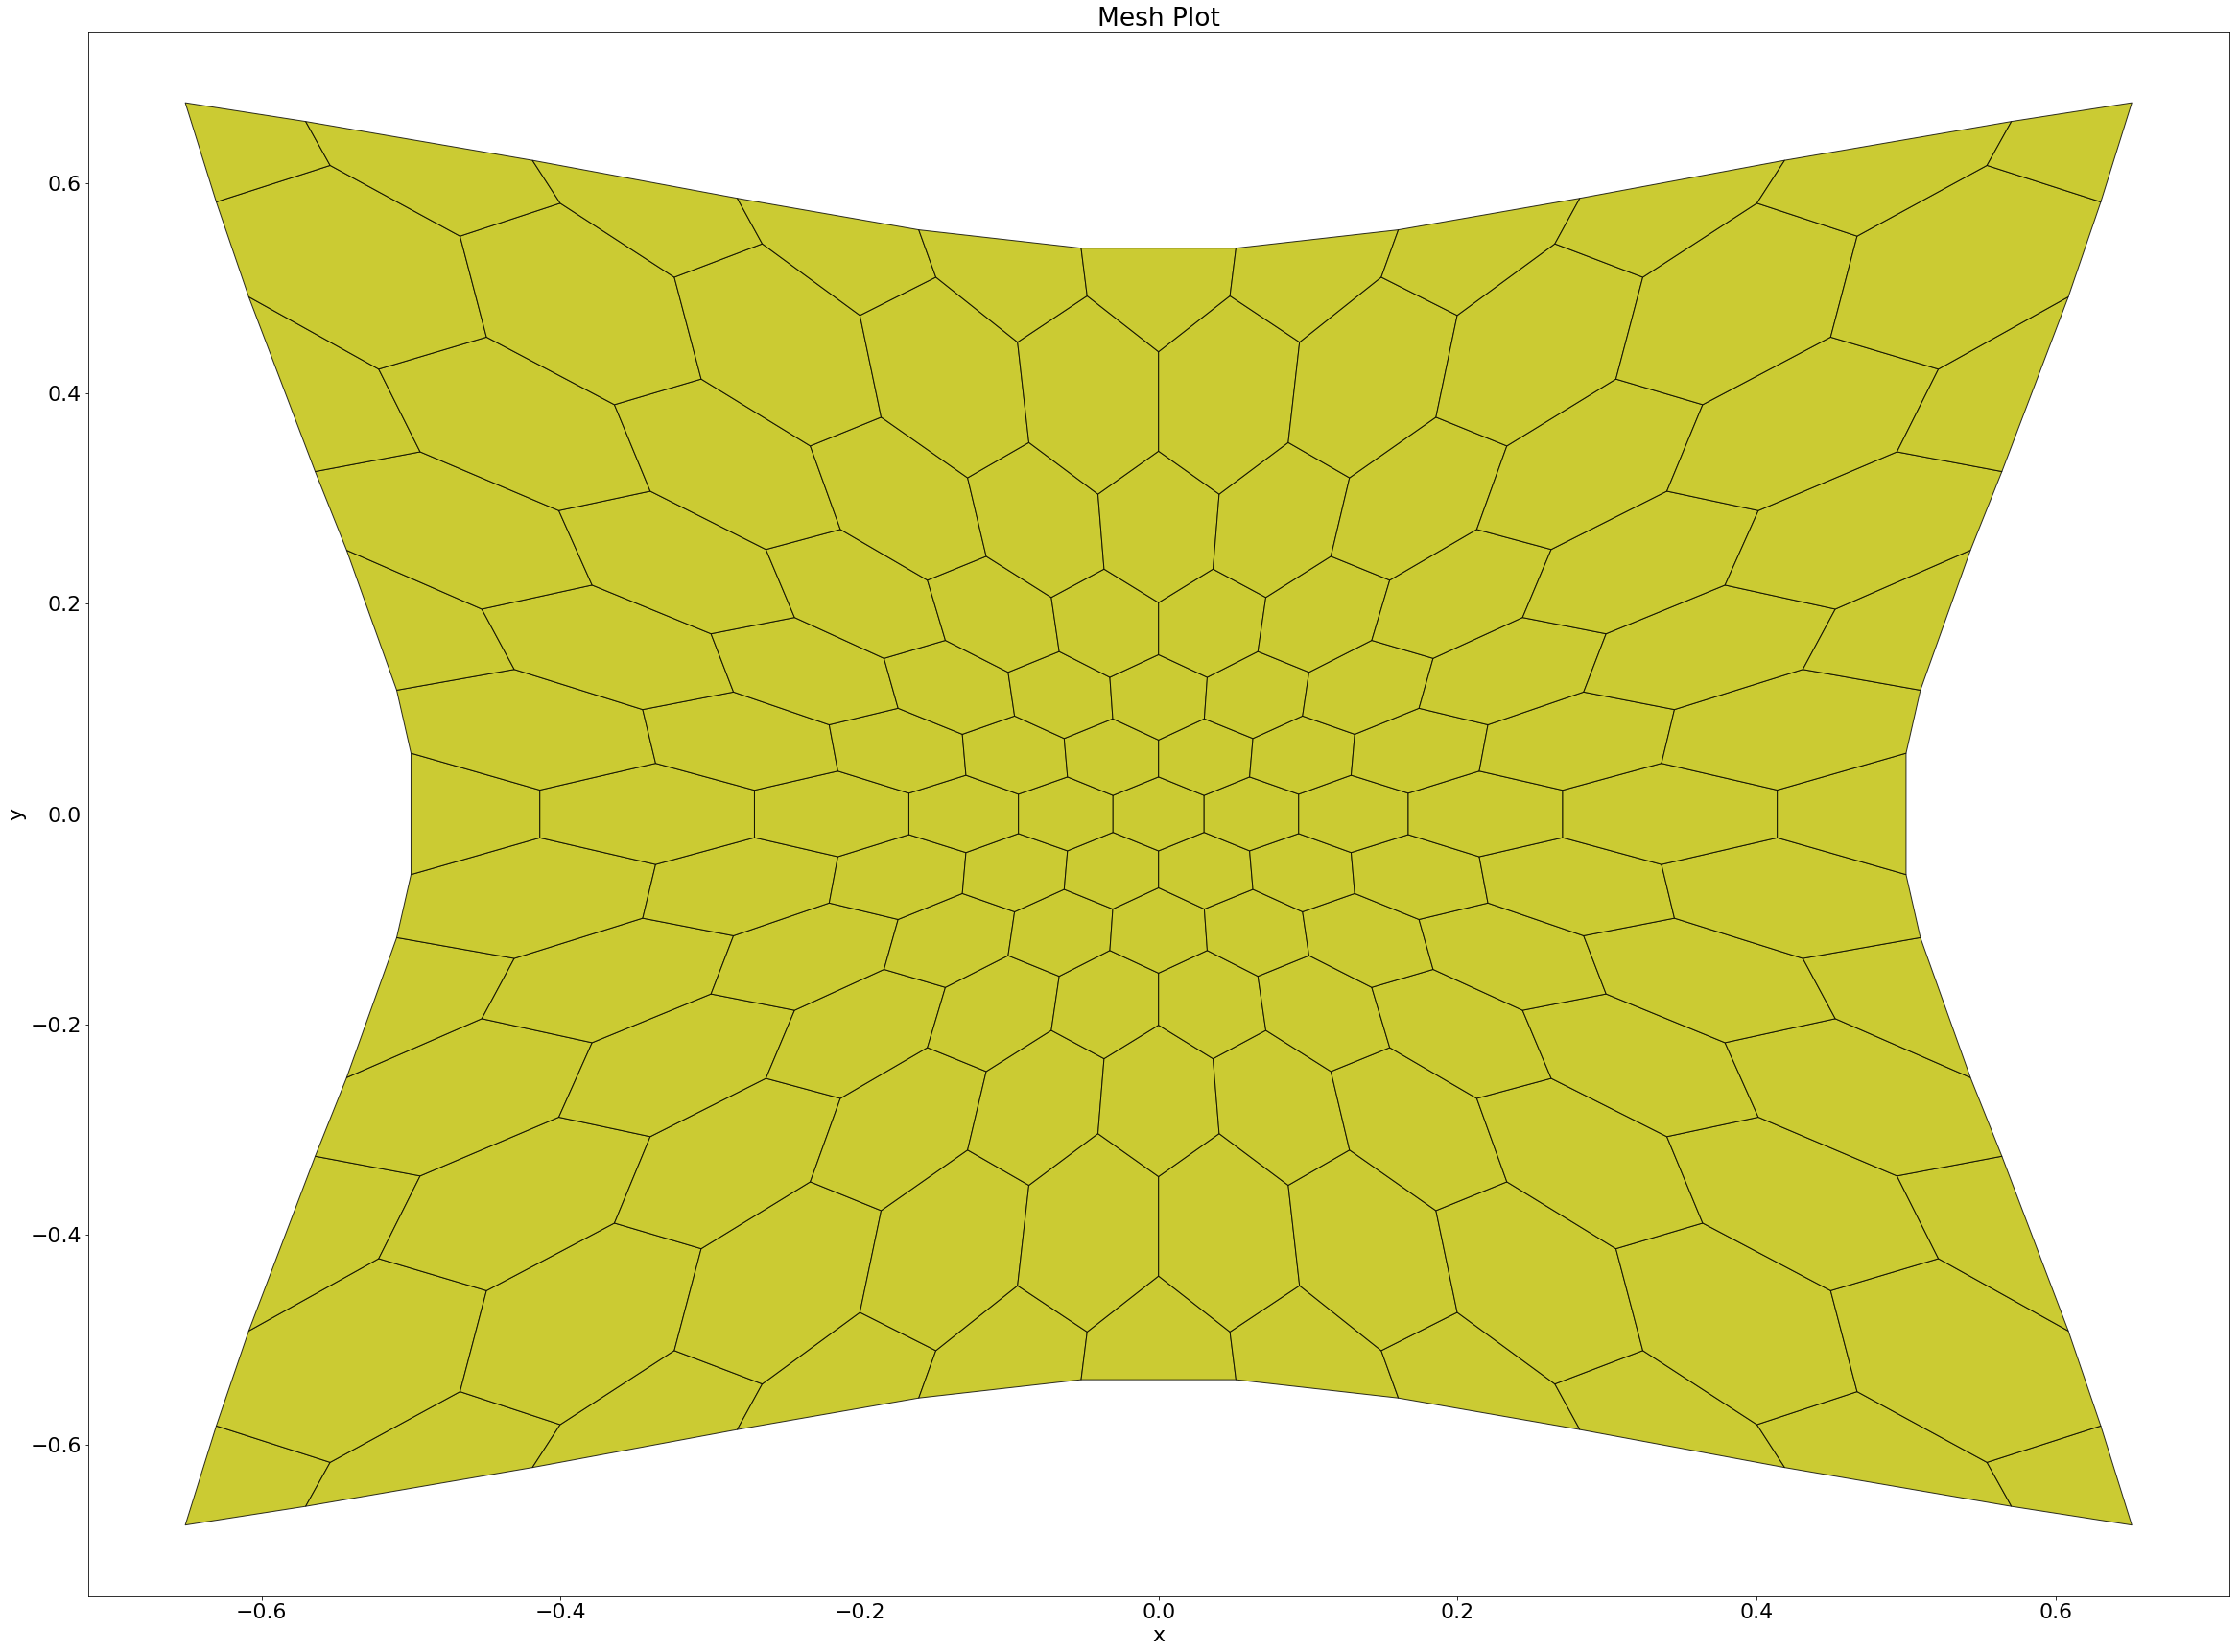

In [8]:
draw(r"/Users/Ivan/Desktop/Visu/mesh_005_hex.dat",
     r"/Users/Ivan/Desktop/Visu/input_cellsid_hex.dat",
     r"/Users/Ivan/Desktop/Visu/input_cnconn_hex.dat",
     r"/Users/Ivan/Desktop/Visu/vals_005_hex.dat",
     'crho')

In [ ]:
#OLD (And hideous)
#for k in range(nc):
#    cx = get_cvert_coords_x(k)
#    cy = get_cvert_coords_y(k)
#    plt.fill(cx, cy, color=viridis(norm_color_list('crho'))[k])